### Medical Image Processing Final Project 2025

This notebook contains the solution to the final project task in the Medical Image Processing course. The task involves visualizing, analyzing, segmenting 3D CT volumes with corresponding segmentation masks for liver and tumor structures, and co-registering an input volume to a reference volume space. 

The project is organized into the following key steps:

1. Loading and sorting CT slices based on spatial metadata to construct a 3D CT volume.
2. Loading and mapping segmentation masks (liver and tumor) to the corresponding CT slices using DICOM spatial metadata.
3. Visualizing representative slices with overlaid segmentation masks to assess anatomical alignment.
4. Constructing a 3D tumor mask volume and generating a rotating Maximum Intensity Projection (MIP) animation to explore tumor distribution.
5. Implementing a semi-automatic segmentation algorithm.
6. Evaluating the segmentation performance using numerical metrics such as precision, sensitivity, and specificity.
7. Visualizing and comparing ground truth and segmented results for qualitative assessment.
8. Rigid Co-registraion of an input volume to a reference volume space

#### Author: Halidu Abdulai

### Table of Content
[Task 1: Loading and Visualizing the Reference CT image](#task-1---loading-and-visualizing-the-reference-ct-image)
- [1.1 Loading and Sorting the Refernce CT image](#loading-and-sorting-ct-images)
- [1.2 Loading and mapping segmentation masks to CT slices](#loading-and-mapping-segmentation-masks-to-ct-slices)
- [1.3 Construction 3D Tumor mask volume](#construct-the-3d-tumor-mask-volume)
- [1.4 Visualizing Sample slices with Liver and Tumor overlays](#visualizing-sample-slices-containing-liver-and-tumor-segmentations)
- [Generating Rotating MIP GIF along the Coronal-Sagittal planes](#generate-rotating-mip-animation)

[Task 2: Semi-Automatic 3D image Segmentation](#task-2-3d-image-segmentation)
- [2.1 Tumor mask bounding-box and centriod extraction](#extracting-tumor-bounding-box-and-centroid)
- [2.2 Estimating Tumor mask using Region Growing Algorithm](#estimating-tumor-region-using-region-growing-algorithm)
- [2.3 Numerical and Visual Performance Evaluation](#evaluation-and-comparison)

[Task 3: 3D Rigid Co-Registration](#task-3-image-co-registration)


### Import Libraries

In [407]:
import pydicom
import highdicom as hd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib
import os
import glob 
import imageio
import SimpleITK as sitk
from collections import defaultdict, Counter

from scipy.ndimage import map_coordinates
from scipy.optimize import minimize
from scipy.optimize import least_squares
import csv
from scipy.ndimage import zoom



#### Task 1 - Loading and Visualizing the Reference CT Image 

In [122]:
# Paths to dataset
ref_ct_dir = r"Data\30_EQP_Ax5.00mm" # Path to reference CT series
input_ct_dir = r"Data\11_AP_Ax5.00mm" # Path to input CT series
tumor_seg_path = r"Data\30_EQP_Ax5.00mm_ManualROI_Tumor.dcm"
liver_seg_path = r"Data\30_EQP_Ax5.00mm_ManualROI_Liver.dcm"
output_dir = "Task1_output"

#### Loading and Sorting CT image

To begin constructing the 3D CT volume, the first task is to load and sort all the CT slices. Since the filenames themselves don’t reflect the actual spatial ordering of the slices, we can't rely on sorting by name. Instead, we can use metadata embedded in each DICOM file.

By exploring the slices in 3D Slicer, I confirmed that the ImagePositionPatient attribute provides the spatial coordinates of each slice, specifically along the z-axis for axial CT scans (since we are working with axial CT scans data). This z-value essentially tells us the order in which the slices should appear in the final 3D volume.

We can take the following steps to load, sort and contruct the 3D volume:

1. Load all DICOM files: Collect all .dcm files from the input directory containing the dicom files for the CT slices. For each file, read it using pydicom and ensure that all files have the same AcquisitionNumber.

2. Sort the slices using z-position: Each slice’s z-position is extracted from ImagePositionPatient[2]. Once all valid slices are collected, sort them based on this z-position so they’d be arranged in the correct anatomical order.

3. Stack pixel data to build the CT volume: After sorting, pull the pixel arrays from each slice and stack them along a new axis using np.stack(..., axis=-1) to form the full 3D volume. This way, each slice forms a 2D image along one axis of the volume, and together they create the complete CT scan.

In [136]:
def load_and_sort_ct_slices(ct_dir):
    """
    Load and sort CT slices, verifying single acquisition and consistent XY position.

    Reads DICOM files, extracts relevant metadata, checks for consistent
    AcquisitionNumber (if present), determines the most common X/Y position
    to handle potential outliers, filters slices based on this common position,
    and sorts the final list by Z-position.

    Args:
        ct_dir (str): Directory containing DICOM files.

    Returns:
        list: A list of dictionaries, where each dictionary contains the
              pydicom dataset ('dataset'), Z-position ('z_pos'), rows ('rows'),
              and columns ('cols') for a slice, sorted by 'z_pos'.

    Raises:
        FileNotFoundError: If no DICOM files are found in the directory.
        ValueError: If no valid CT slices are loaded, if multiple
                    AcquisitionNumbers are detected in the final set, or if
                    no dominant X/Y position can be determined.
    """
    ct_files = glob.glob(os.path.join(ct_dir, '*.dcm')) # Get all DICOM files

    if not ct_files:
        raise FileNotFoundError(f"Error: No DICOM files found in {ct_dir}")

    print(f"Found {len(ct_files)} CT files. Performing initial scan...")

    # Initial Scan for Position and Basic Info
    preliminary_slice_info = []
    all_series_uids = set()

    for f_path in ct_files:
        try:
            # Read only necessary tags initially for speed and filtering
            ds = pydicom.dcmread(f_path, stop_before_pixels=True) 

            # Check for essential tags
            if not all(hasattr(ds, tag) for tag in ['ImagePositionPatient', 'Rows', 'Columns', 'SeriesInstanceUID']):
                print(f"Skipping file {f_path}: Missing required header tags.")
                continue

             # Check ImagePositionPatient length
            if len(ds.ImagePositionPatient) < 3:
                 # print(f"Skipping file {f_path}: ImagePositionPatient has fewer than 3 values.")
                 continue

            current_series_uid = ds.SeriesInstanceUID
            all_series_uids.add(current_series_uid)

            # Store preliminary info including the file path
            preliminary_slice_info.append({
                'path': f_path,
                'x_pos': float(ds.ImagePositionPatient[0]),
                'y_pos': float(ds.ImagePositionPatient[1]),
                'z_pos': float(ds.ImagePositionPatient[2]),
                'rows': ds.Rows,
                'cols': ds.Columns,
                'series_uid': current_series_uid,
                'acq_num': ds.get('AcquisitionNumber', None) # Get AcqNum if exists
            })

        except Exception as e:
            print(f"Warning: Error during initial read of {f_path}: {e}")

    if not preliminary_slice_info:
        raise ValueError("Error: No files with required DICOM headers found.")

    # Determine Dominant Series UID (if multiple exist) 
    if len(all_series_uids) > 1:
        print(f"Warning: Multiple SeriesInstanceUIDs found: {all_series_uids}. Attempting to find the most common one.")
        series_counts = Counter(info['series_uid'] for info in preliminary_slice_info)
        dominant_series_uid, _ = series_counts.most_common(1)[0]
        print(f"  Proceeding with the most common SeriesInstanceUID: {dominant_series_uid}")
        # Filter preliminary list by dominant series
        preliminary_slice_info = [info for info in preliminary_slice_info if info['series_uid'] == dominant_series_uid]
        if not preliminary_slice_info:
             raise ValueError(f"Error: No slices found for the dominant SeriesInstanceUID {dominant_series_uid}.")
    elif len(all_series_uids) == 1:
        dominant_series_uid = list(all_series_uids)[0]
        print(f"All files belong to SeriesInstanceUID: {dominant_series_uid}")
    else: # Should not happen if preliminary_slice_info is not empty
         raise ValueError("Error: Could not determine SeriesInstanceUID.")


    # Determine Dominant X/Y Position 
    # Use rounding to group similar float positions
    pos_precision = 2 # Number of decimal places to consider for grouping
    xy_positions = [(round(info['x_pos'], pos_precision), round(info['y_pos'], pos_precision))
                    for info in preliminary_slice_info]

    if not xy_positions:
         raise ValueError("Error: No valid preliminary slice info to determine position.")

    position_counts = Counter(xy_positions)
    if not position_counts:
         raise ValueError("Error: Could not count XY positions.")

    most_common_xy, count = position_counts.most_common(1)[0]
    reference_x_rounded, reference_y_rounded = most_common_xy
    print(f"Most common rounded X/Y position: ({reference_x_rounded}, {reference_y_rounded}) found in {count} slices.")

    # Filter Slices based on Dominant X/Y Position 
    pos_tolerance = 10**(-pos_precision) / 2 # Tolerance based on rounding precision
    filtered_slice_info = []
    excluded_count = 0
    for info in preliminary_slice_info:
        # Compare original float values using tolerance derived from rounding
        if np.isclose(info['x_pos'], reference_x_rounded, atol=pos_tolerance) and \
           np.isclose(info['y_pos'], reference_y_rounded, atol=pos_tolerance):
            filtered_slice_info.append(info)
        else:
            print(f"Warning: Excluding file {info['path']}. Its X/Y position "
                  f"({info['x_pos']:.2f}, {info['y_pos']:.2f}) differs significantly "
                  f"from the dominant rounded position ({reference_x_rounded}, {reference_y_rounded}).")
            excluded_count += 1

    if excluded_count > 0:
        print(f"Excluded {excluded_count} slice(s) due to inconsistent X/Y position.")

    if not filtered_slice_info:
        raise ValueError("Error: No slices remaining after filtering by X/Y position.")

    # Final Loading, Acquisition Check, and Sorting 
    ct_slices = []
    first_acquisition_number = None
    loaded_count = 0

    print(f"Loading pixel data and performing final checks for {len(filtered_slice_info)} slices...")
    for info in filtered_slice_info:
        try:
            # Now read the full dataset including pixel data
            ds = pydicom.dcmread(info['path'])

            # Acquisition Number Check (only on filtered slices)
            current_acquisition_number = info['acq_num'] # Already extracted

            if first_acquisition_number is None and current_acquisition_number is not None:
                first_acquisition_number = current_acquisition_number
            elif current_acquisition_number is not None and first_acquisition_number is not None:
                if current_acquisition_number != first_acquisition_number:
                    raise ValueError(
                        f"Error: Multiple AcquisitionNumbers detected within the consistent X/Y group! "
                        f"Expected {first_acquisition_number}, but found {current_acquisition_number} in file {info['path']}."
                    )

            # Check if pixel data exists after full read
            if not hasattr(ds, 'pixel_array'):
                 print(f"Warning: Skipping file {info['path']}: Missing pixel_array after full read.")
                 continue

            # Store final slice data
            ct_slices.append({
                'dataset': ds,
                'z_pos': info['z_pos'],
                'rows': info['rows'],
                'cols': info['cols']
            })
            loaded_count += 1

        except Exception as e:
            print(f"Error during final read/processing of {info['path']}: {e}")


    # Final Checks and Sorting
    if not ct_slices:
        raise ValueError("Error: No valid CT slices were loaded after final checks.")

    # Sort slices based on the Z-coordinate
    ct_slices.sort(key=lambda x: x['z_pos'])

    print(f"Successfully loaded and sorted {len(ct_slices)} CT slices.")
    if first_acquisition_number is not None:
        print(f"Verified all loaded slices belong to AcquisitionNumber: {first_acquisition_number}")
    elif len(ct_slices) > 0:
         print("Note: AcquisitionNumber tag was not found or consistently absent in loaded slices.")
    print(f"Verified all loaded slices have consistent X/Y position (approx. {reference_x_rounded}, {reference_y_rounded})")


    return ct_slices

In [137]:
ref_ct_slices = load_and_sort_ct_slices(ref_ct_dir)
if not ref_ct_slices:
    raise ValueError("Error: No valid CT slices loaded.")

# Create a 3D numpy array to hold the CT volume
# Note: All slices have the same dimensions and orientation upon inspection with 3D Slicer
try:
    ct_volume = np.stack([s['dataset'].pixel_array for s in ref_ct_slices], axis=-1)
    print(f"Created CT volume with shape: {ct_volume.shape}")
except Exception as e:
    print(f"Could not stack CT slices into volume: {e}")
    ct_volume = None 

Found 42 CT files. Performing initial scan...
All files belong to SeriesInstanceUID: 1801040320200103051513090319.222.3.4
Most common rounded X/Y position: (-181.75, -153.06) found in 41 slices.
Excluded 1 slice(s) due to inconsistent X/Y position.
Loading pixel data and performing final checks for 41 slices...
Successfully loaded and sorted 41 CT slices.
Verified all loaded slices belong to AcquisitionNumber: 3
Verified all loaded slices have consistent X/Y position (approx. -181.75, -153.06)
Created CT volume with shape: (512, 512, 41)


#### Loading and Mapping Segmentation Masks to CT Slices
Next, we need to load and map the segmentations (liver and tumor) to the CT slices using ImagePositionPatient.
To do this, I followed the following steps:

1. Load the segmentation file (tumor or liver): 
We begin by reading in the `segmentation DICOM file using pydicom`. 

2. Parse the loaded DICOM dataset into a segmentation object using highdicom’s `Segmentation` class: 
Once the dataset is loaded, we use highdicom.seg.Segmentation.from_dataset() to convert it into a highdicom Segmentation object. This makes it easier to access the segmentation pixel data and related metadata.

3. Loop through the segmentation frames and extract their Z-positions:
We iterate through the PerFrameFunctionalGroupsSequence of the DICOM segmentation dataset. For each frame, we access the z-coordinate (axial position) using PlanePositionSequence[0].ImagePositionPatient[2]. This is the same metadata field we used earlier when sorting CT slices.

4. Map each frame (mask) to its corresponding Z-position:
Using the extracted z-position as a key, we store each binary mask frame in a dictionary (segmentations). For each z-position, we create a sub-dictionary where each segmentation type (e.g., ‘Liver’, ‘Tumor’) is stored separately. We apply a threshold to the pixel values so that each mask becomes binary (i.e., values > 0 are considered part of the segmented region).

At the end of this step, we’ve created a mapping between z-positions and their corresponding segmentation masks for both liver and tumor. 

>Note: I am sure there may be a simpler way to load and map the segmentation masks to the corresponding CT slices. However, highdicom's docs seemed a bit old and wasn't really helpful. I thought through the above apprach, tried it, and it worked for me!

In [141]:
def load_segmentation(seg_path: str, seg_name: str, segmentations: dict) -> dict:
    """
    Loads segmentation frames and maps them to Z positions.

    Args:
        seg_path (str): Path to the DICOM segmentation file.
        seg_name (str): Name to assign to this segmentation (e.g., 'Liver', 'Tumor').
        segmentations (dict): Dictionary (keyed by Z-pos) to store loaded masks.
                              This dictionary is modified in place.

    Returns:
        dict: The updated segmentations dictionary.
    """
    if not os.path.exists(seg_path):
        print(f"Warning: Segmentation file not found at {seg_path}")
        return segmentations # Return the dictionary unchanged

    try:
        seg_ds = pydicom.dcmread(seg_path) 
        # Use highdicom to parse the segmentation object
        seg = hd.seg.Segmentation.from_dataset(seg_ds)
        print(f"Loaded {seg_name} segmentation with {len(seg.pixel_array)} frames.")

        # Extract pixel array (NumPy array)
        seg_pixel_array = seg.pixel_array # Shape: (frames, rows, columns) 
        
        # Determine number of regions of interest (ROIs) in the segmentation
        unique_labels = np.unique(seg_pixel_array) # Get unique labels in the segmentation
        unique_labels = unique_labels[unique_labels > 0]  # Exclude background (0) 
        print(f"Found {len(unique_labels)} unique {'regions' if len(unique_labels) > 1 else 'region'} in {seg_name} segmentation")

        # Check if PerFrameFunctionalGroupsSequence exists
        if not hasattr(seg_ds, 'PerFrameFunctionalGroupsSequence'):
             print(f"Error: Segmentation file {seg_path} missing PerFrameFunctionalGroupsSequence. Cannot map frames.")
             return segmentations

        # Map frames to CT slices using ImagePositionPatient
        mapped_frames = 0
        for i, frame_group in enumerate(seg_ds.PerFrameFunctionalGroupsSequence):
             # Check structure for position information
            if not hasattr(frame_group, 'PlanePositionSequence') or \
               not frame_group.PlanePositionSequence or \
               not hasattr(frame_group.PlanePositionSequence[0], 'ImagePositionPatient'):
                 print(f"Warning: Frame {i} in {seg_path} missing position info. Skipping.")
                 continue

            # Get position for this frame
            frame_pos = frame_group.PlanePositionSequence[0].ImagePositionPatient
            frame_z_pos = float(frame_pos[2])

            # Store the mask (frame) in our dictionary, keyed by Z-position
            if frame_z_pos not in segmentations:
                segmentations[frame_z_pos] = {}
            # Store the actual mask data for this segmentation type
            segmentations[frame_z_pos][seg_name] = (seg_pixel_array[i] > 0) # binary mask
            mapped_frames += 1

        print(f"Mapped {mapped_frames} {seg_name} frames to Z-positions.")

    except Exception as e:
        print(f"Error loading or processing {seg_name} segmentation from {seg_path}: {e}")

    return segmentations

In [142]:
segmentations = defaultdict(str) # Dictionary to hold masks keyed by Z-position

# Load both liver and tumor segmentations
segmentations = load_segmentation(liver_seg_path, 'Liver', segmentations)
segmentations = load_segmentation(tumor_seg_path, 'Tumor', segmentations)

Loaded Liver segmentation with 28 frames.
Found 1 unique region in Liver segmentation
Mapped 28 Liver frames to Z-positions.
Loaded Tumor segmentation with 14 frames.
Found 1 unique region in Tumor segmentation
Mapped 14 Tumor frames to Z-positions.


#### Visualizing sample slices containing Liver and Tumor Segmentations
After loading and organizing the CT slices and segmentation masks, the next step is to visualize some representative slices where both liver and tumor segmentations are present. This allows us to qualitatively assess the correctness of the masks and their spatial alignment with the underlying anatomy.

To achieve this, I followed these steps:

1. Apply windowing to enhance CT contrast:
CT data is stored in Hounsfield Units (HU), and not all HU values are equally useful for soft tissue visualization. Using a soft tissue window (level = 50, width = 400), I rescaled the CT intensities to the display range [0, 1]. This makes anatomical structures easier to see. 

2. Prepare RGB version of the CT image:
After windowing, the single-channel grayscale image is expanded into three channels using np.stack() to make it RGB. This allows us to overlay colored segmentation masks later on.

3. Overlay segmentation masks with alpha blending:
Using the defined function, I blended the liver and tumor masks on top of the CT slice by first blending the liver with the CT image, and then the resulting image is blended with the tumor mask. Each mask is applied with its respective color—green for liver and red for tumor—and an alpha value of 0.25 for transparency. This helps in visualizing where each structure lies in relation to the anatomy without completely obscuring the CT image.

4. Display the images side-by-side:
For each slice that contains both a liver and tumor mask, I display three panels:
    - The raw CT slice (in HU),
    - The windowed CT image,
    - The final composite image with liver and tumor overlays.

In [143]:
# Alpha Fusion Function 
def apply_alpha_overlay(image_rgb: np.ndarray, mask: np.ndarray, color: tuple, alpha: float):
    """
    Apply alpha blending of a mask onto an RGB image.
    
    Args:
        image_rgb: RGB image (H, W, 3) in [0, 1].
        mask: Binary mask (H, W).
        color: RGB tuple (R, G, B).
        alpha: Alpha value for blending.
    
    Returns:
        RGB image with alpha-blended overlay applied to only the masked regions.
    """
    # Create a copy of the image to avoid modifying the original
    blended = image_rgb.copy()
    
    # Create a boolean mask where the mask is non-zero
    mask_bool = mask > 0
    
    # Apply the blending only on the pixels where the mask is True
    for c in range(3):  # Iterate over the RGB channels
        blended[..., c] = np.where(mask_bool, 
                                   (1 - alpha) * image_rgb[..., c] + alpha * color[c], 
                                   image_rgb[..., c])
    
    return blended



# CT Windowing Function 
def apply_window(image, level, width):
    """
    Apply windowing to a CT image using the specified window level and width.

    Windowing enhances the visual contrast of CT images by mapping a selected range
    of Hounsfield Unit (HU) values to the display intensity range [0, 1].

    Args:
        image (np.ndarray): 2D array representing the CT slice (typically in HU).
        level (float): Window level (center of the HU range to display).
        width (float): Window width (range of HU values to include around the level).

    Returns:
        np.ndarray: Normalized image array with values scaled to [0, 1] based on the
                    specified windowing parameters.
    """
    lower = level - (width / 2)
    upper = level + (width / 2)
    image = image.astype(np.float32)
    windowed = np.clip(image, lower, upper)
    norm_factor = (upper - lower) if (upper - lower) != 0 else 1.0
    return (windowed - lower) / norm_factor


Visualizing slices containing both Liver and Tumor masks...
Processing Slice Index: 18, Z-Position: -152.12


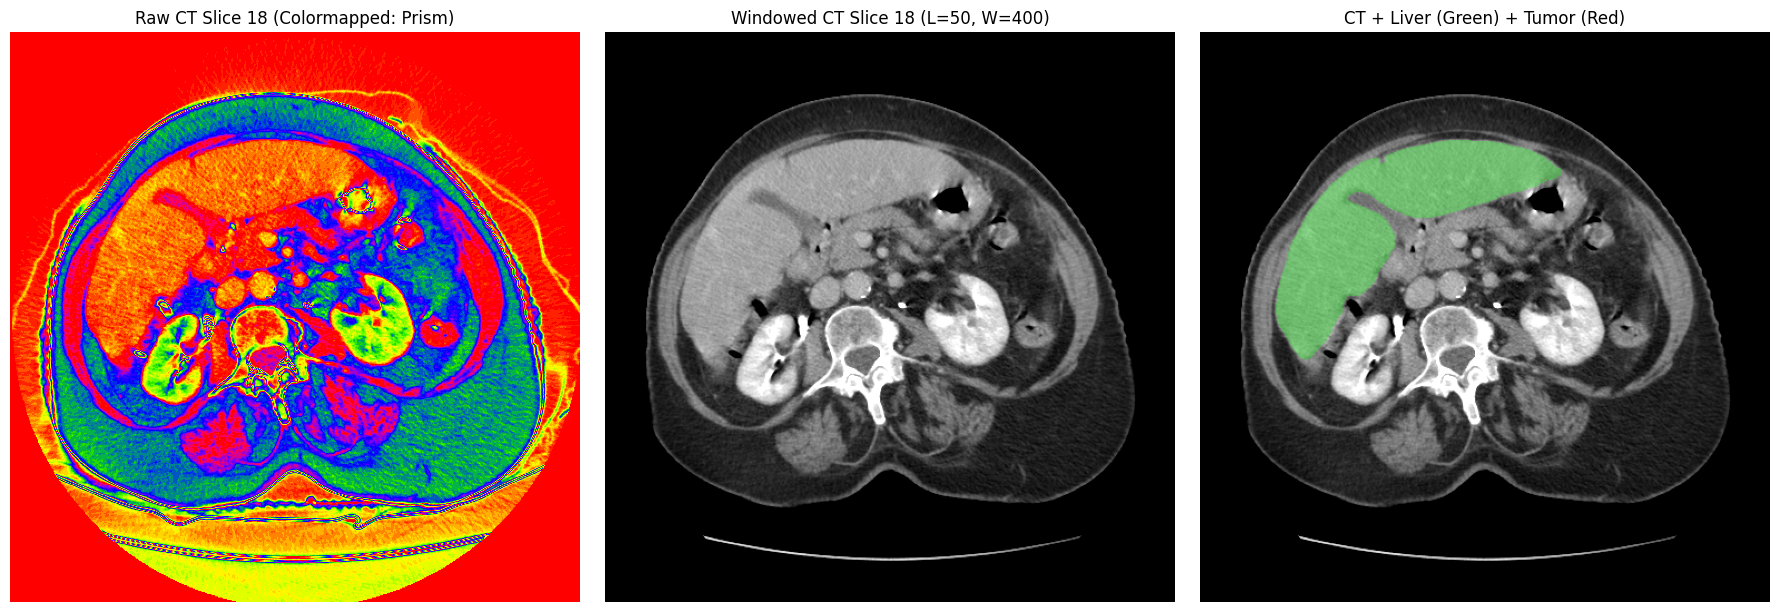

Processing Slice Index: 19, Z-Position: -147.12


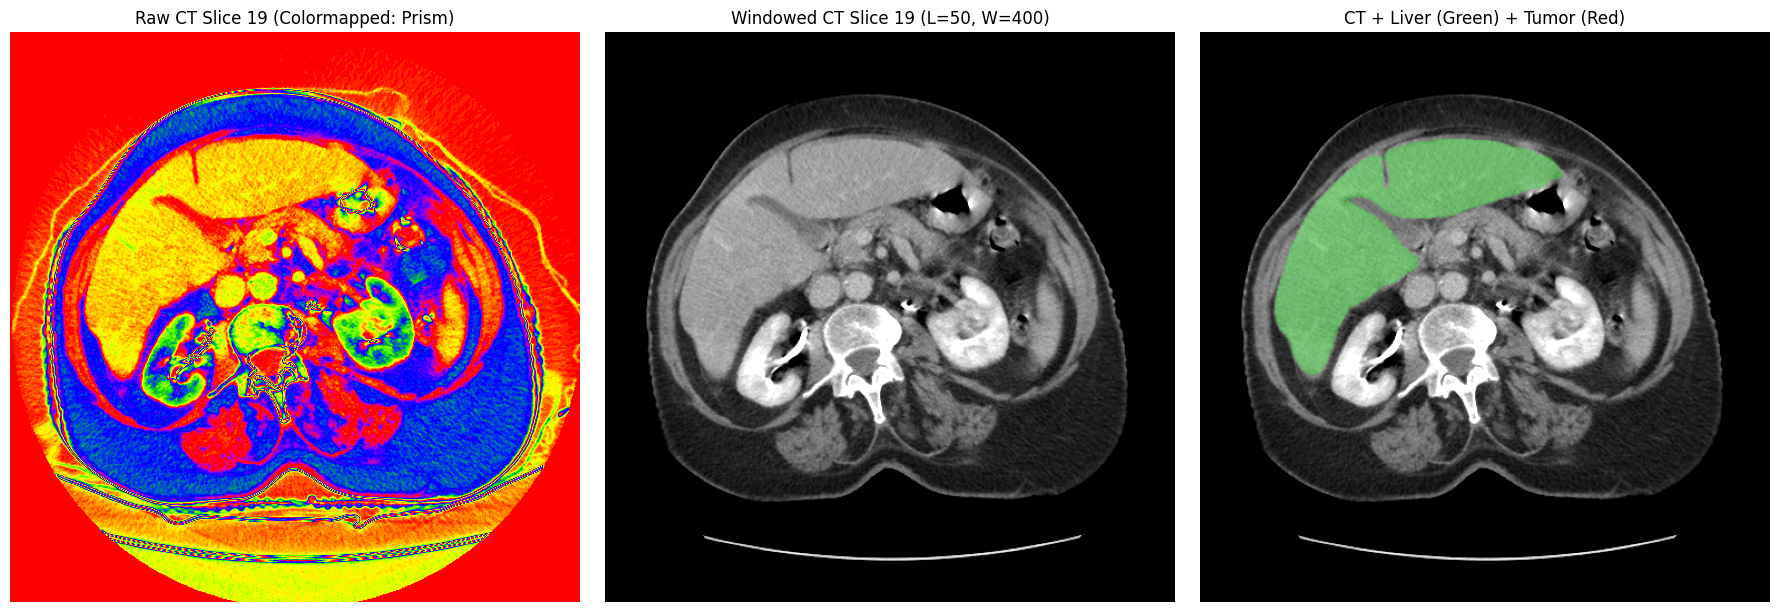

Processing Slice Index: 25, Z-Position: -117.12


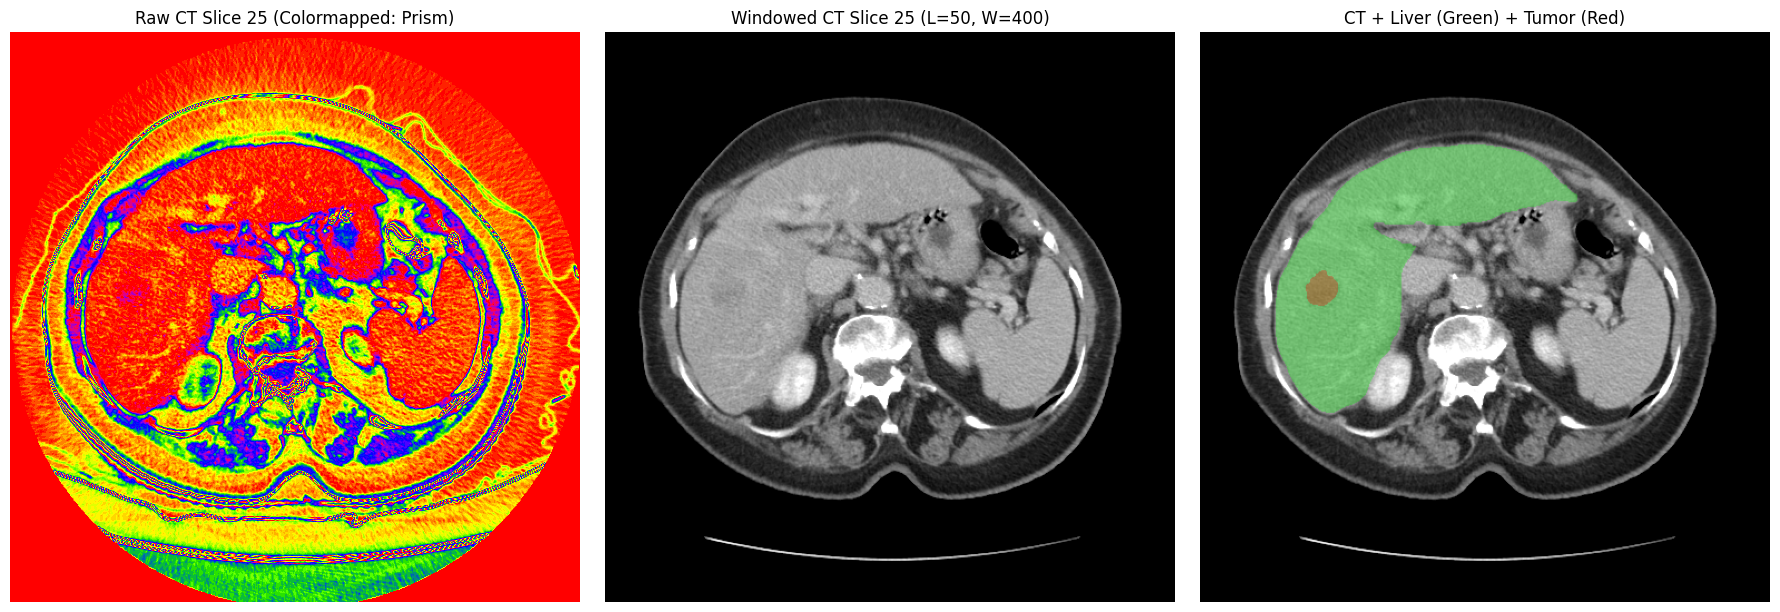

Processing Slice Index: 26, Z-Position: -112.12


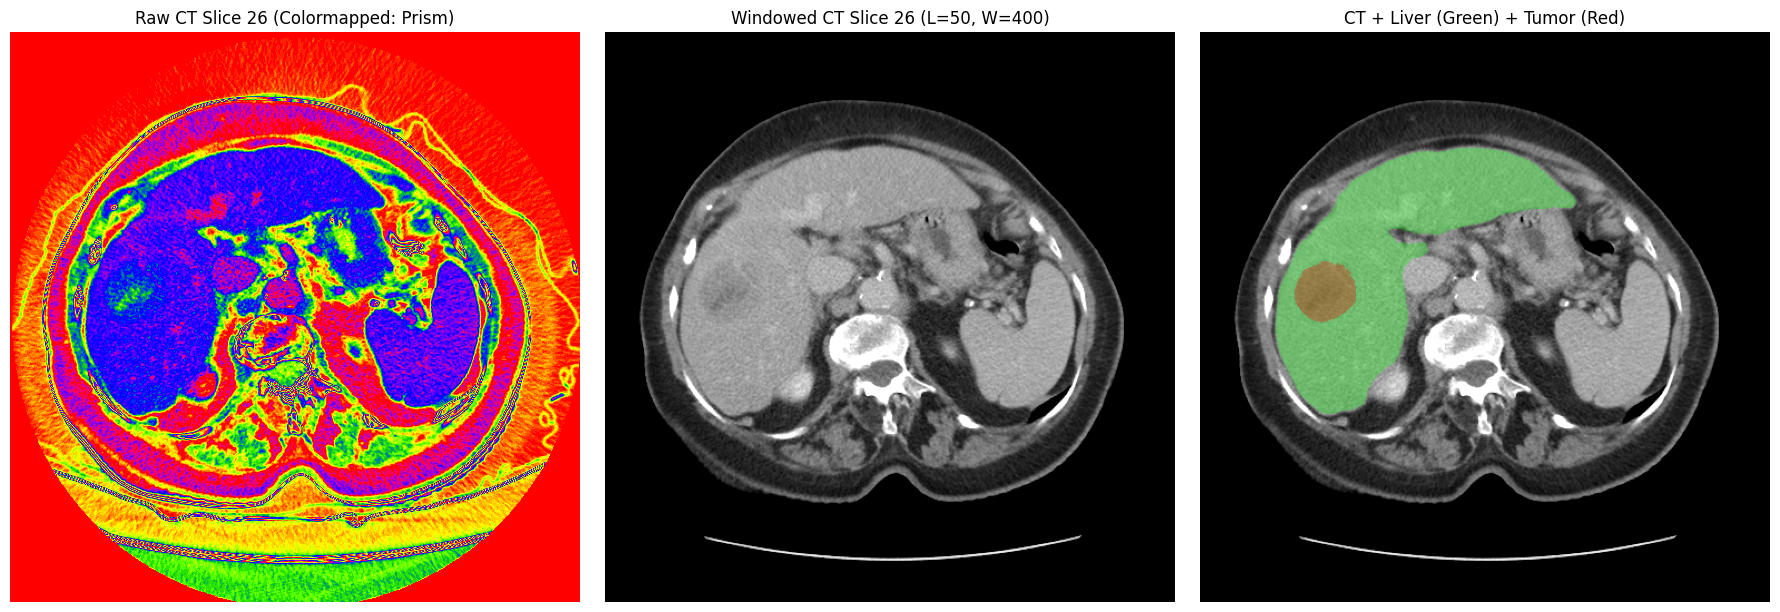

Processing Slice Index: 27, Z-Position: -107.12


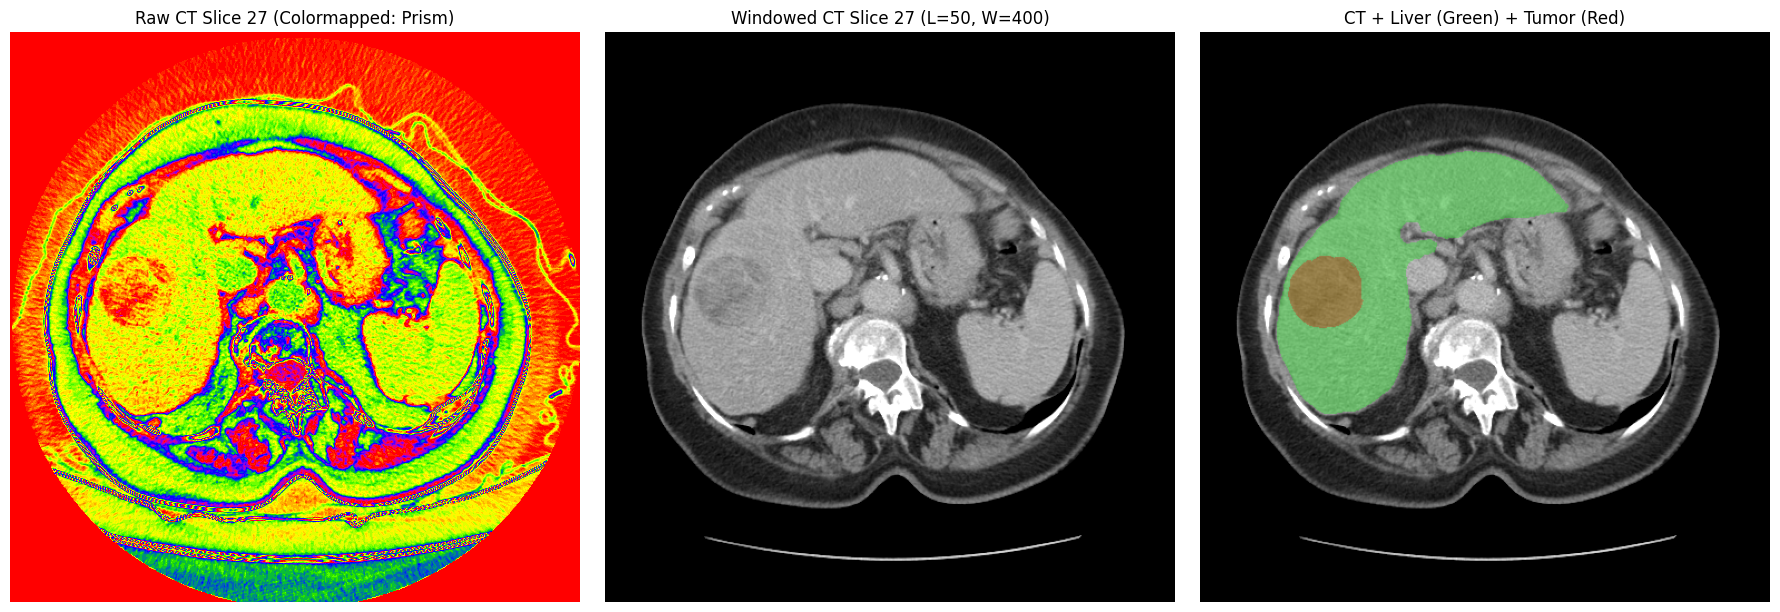

Processing Slice Index: 28, Z-Position: -102.12


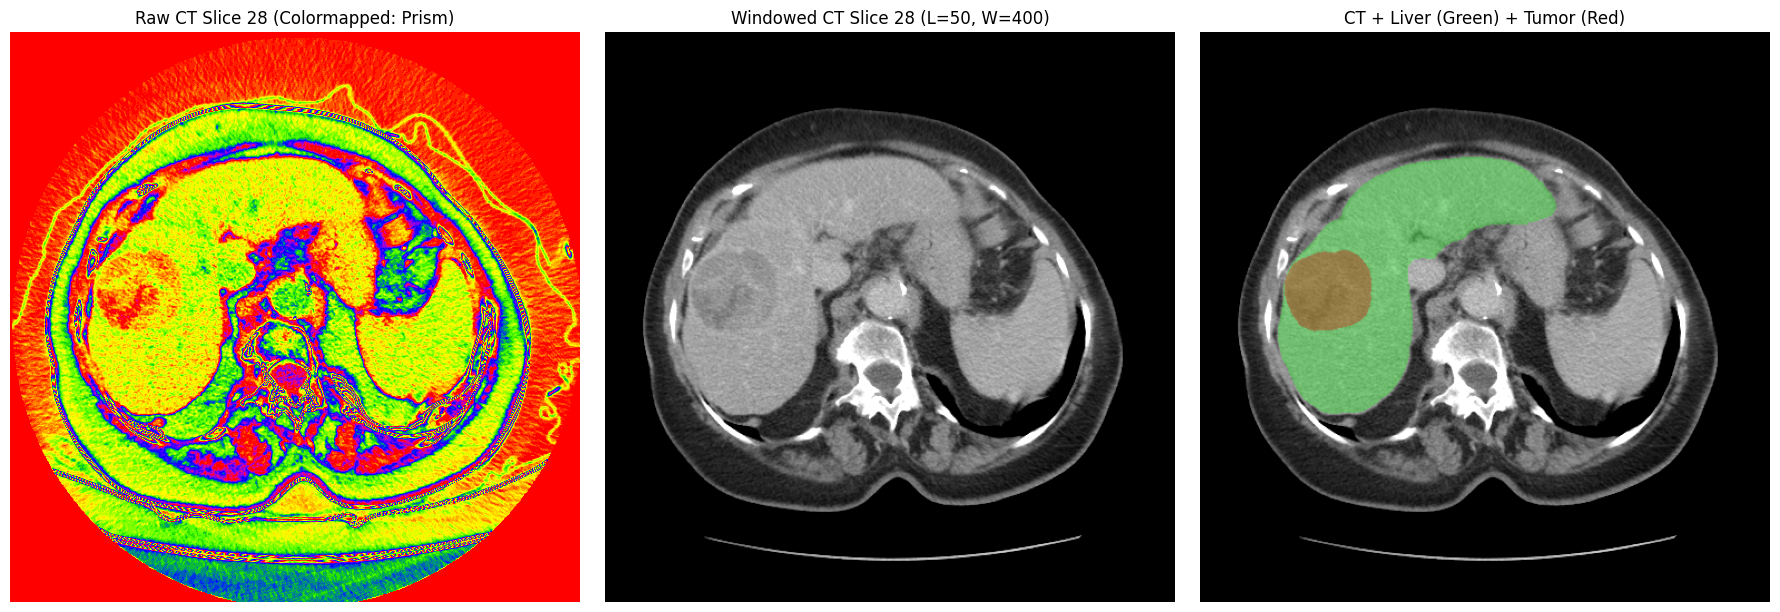

Processing Slice Index: 29, Z-Position: -97.12


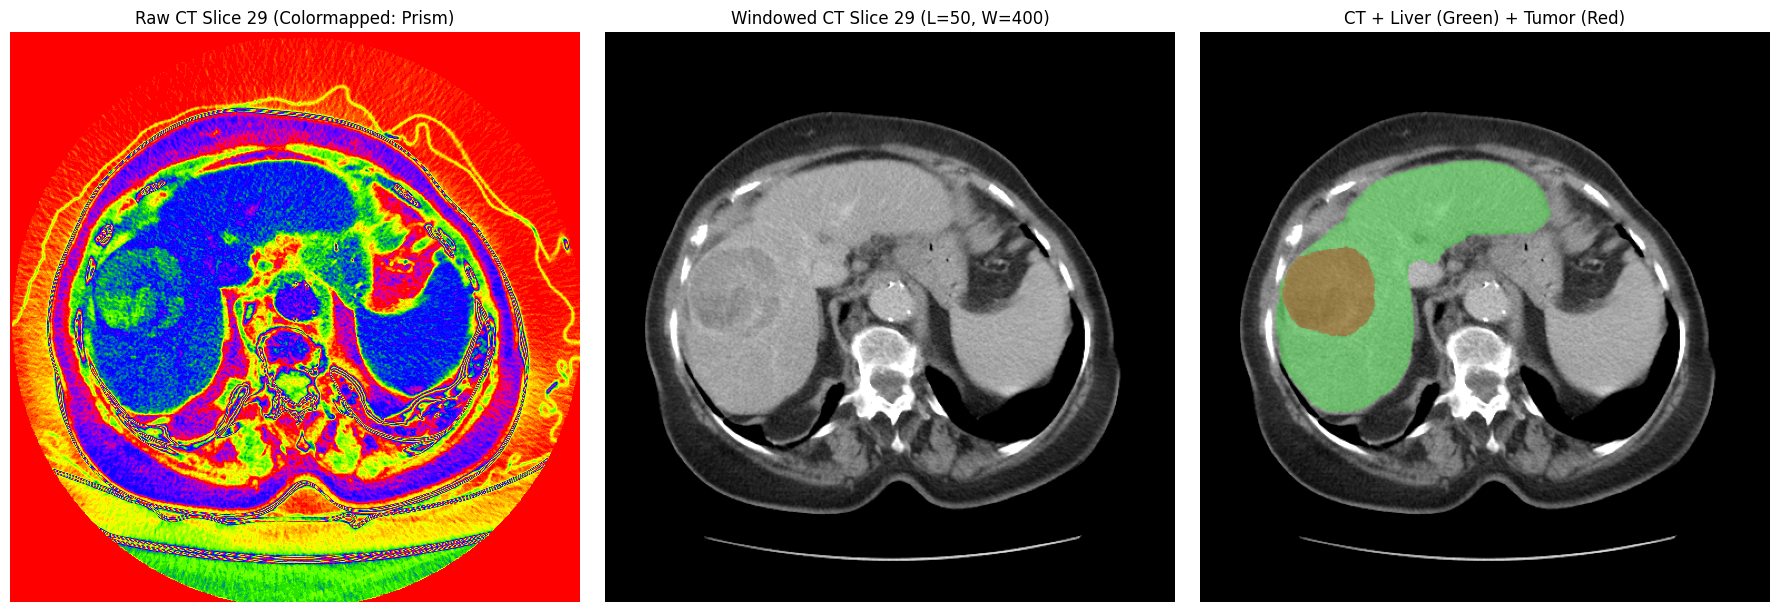

Reached display limit (7 slices). Stopping visualization.

Visualized 7 slices.


In [144]:
# Visualization Parameters 
window_level = 50         # Soft tissue window level
window_width = 400        # Soft tissue window width
liver_color = (0.0, 1.0, 0.0)   # Green
tumor_color = (1.0, 0.0, 0.0)   # Red
alpha = 0.3             # Transparency for overlay
max_slices_to_display = 7

print("\nVisualizing slices containing both Liver and Tumor masks...")

found_slices_count = 0

# Loop through CT slices and their corresponding segmentations
for i, ct_slice_info in enumerate(ref_ct_slices):
    ct_slice_data = ct_slice_info['dataset'].pixel_array
    ct_slice_z_pos = ct_slice_info['z_pos']

    # Match segmentations by Z-position
    slice_segmentations = None
    for seg_z, masks in segmentations.items():
        if np.isclose(ct_slice_z_pos, seg_z, atol=1e-3):
            slice_segmentations = masks
            break

    # Continue only if both masks exist
    if not (slice_segmentations and 'Liver' in slice_segmentations and 'Tumor' in slice_segmentations):
        continue

    if found_slices_count >= max_slices_to_display:
        print(f"Reached display limit ({max_slices_to_display} slices). Stopping visualization.")
        break

    found_slices_count += 1
    print(f"Processing Slice Index: {i}, Z-Position: {ct_slice_z_pos:.2f}")

    # Apply windowing and convert to RGB
    ct_windowed = apply_window(ct_slice_data, level=window_level, width=window_width)
    ct_rgb = np.stack([ct_windowed] * 3, axis=-1)

    # Apply Liver mask overlay
    liver_mask = slice_segmentations['Liver'] > 0
    fused_img = apply_alpha_overlay(ct_rgb, liver_mask, liver_color, alpha)

    # Apply Tumor mask overlay
    tumor_mask = slice_segmentations['Tumor'] > 0
    fused_img = apply_alpha_overlay(fused_img, tumor_mask, tumor_color, alpha)

    # Visualize
    plt.figure(figsize=(18, 6))

    # Raw CT (pre-windowing)
    plt.subplot(1, 3, 1)
    plt.imshow(ct_slice_data, cmap=matplotlib.colormaps['prism'])
    plt.title(f'Raw CT Slice {i} (Colormapped: Prism)')
    plt.axis('off')

    # Windowed CT image
    plt.subplot(1, 3, 2)
    plt.imshow(ct_windowed, cmap="gray") 
    plt.title(f'Windowed CT Slice {i} (L={window_level}, W={window_width})')
    plt.axis('off')

    # Composite with overlays
    plt.subplot(1, 3, 3)
    plt.imshow(fused_img)
    plt.title(f'CT + Liver (Green) + Tumor (Red)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

if found_slices_count == 0:
    print("No slices found containing both Liver and Tumor segmentations.")
else:
    print(f"\nVisualized {found_slices_count} slices.")

#### Construct the 3D Tumor Mask Volume
Once we’ve confirmed the spatial alignment of the CT slices and segmentation masks, the next step is to construct a 3D tumor mask volume. This volume will have the same spatial dimensions as the CT image and will store the tumor masks across all relevant slices.

Here’s how I approached it:

1. Initialize the 3D mask volume:
I extracted the number of rows and columns from the first CT slice (since all slices share the same shape) and initialized an empty 3D array with shape (rows, cols, num_slices). I used float32 as the data type to allow for flexibility in case we want to apply interpolation later on, though uint8 would be sufficient for binary masks.

2. Loop through each CT slice and match with segmentation data:
For every CT slice, I retrieved its z-position and searched the segmentations dictionary for the closest matching z-position. Because floating-point precision can introduce small mismatches, I used np.isclose() with a small tolerance (atol=1e-3) to make sure the match is valid.

3. Insert tumor masks into the volume:
If a tumor mask was found for the current slice and its dimensions matched the expected CT size, it is inserted into the corresponding slice index in the 3D mask volume. The mask was cast to uint8 to ensure binary values (0 for background, 1 for tumor region).

In [145]:
def construct_3d_mask(ct_slices, segmentations, segment_name='Tumor'):
    """
    Constructs a 3D tumor mask volume from the provided CT slices and segmentation masks.

    Args:
        ct_slices (list): A list of dictionaries, each containing data for a single CT slice.
                           Each dictionary should have keys 'rows', 'cols', and 'z_pos', which 
                           represent the slice's dimensions and its Z-position in the scan.
        segmentations (dict): A dictionary where keys are Z-positions (float) and values are 
                              dictionaries containing segmentations for each slice. Each segmentation 
                              dictionary should include the 'segment_name' (e.g., 'Tumor') key, which 
                              holds the binary mask for that segment.
        segment_name (str, optional): The name of the segmentation to be used. Defaults to 'Tumor'.

    Returns:
        np.ndarray: A 3D numpy array representing the tumor mask volume, where each slice contains 
                    the corresponding tumor mask. If no tumor masks are found, an empty 3D array is returned.
        
    Raises:
        ValueError: If the `ct_slices` list is empty or if no matching tumor masks are found.
        
    Notes:
        - The function attempts to match each CT slice's Z-position to the closest available segmentation in 
          the `segmentations` dictionary using a tolerance of 1e-3.
        - If a tumor mask is found for a slice, it is placed in the corresponding slice of the 3D mask volume.
        - If the tumor mask's dimensions do not match the CT slice dimensions, that slice is skipped with a warning.
        - The resulting 3D mask is initialized with `dtype=np.int8`, suitable for binary masks.
    """

    print(f"\nConstructing 3D {segment_name} Mask Volume...")

    if not ct_slices: # Check if CT slices are still available in the environment
        raise ValueError("Error: Cannot construct 3D mask without loaded CT slices.")

    # Determine dimensions from the first loaded CT slice (all slices are of the same size)
    rows = ct_slices[0]['rows']
    cols = ct_slices[0]['cols']
    num_slices = len(ct_slices)

    # Initialize an empty 3D volume for the tumor mask
    # Using float32 initially might be better if interpolation is used later,
    # but uint8 is fine for binary masks and MIP. Let's use uint8.
    mask_3d = np.zeros((rows, cols, num_slices), dtype=np.int8)
    print(f"Initialized 3D mask volume with shape: ({rows}, {cols}, {num_slices})")

    # Populate the 3D mask volume
    slices_with_mask = 0
    for k, slice_info in enumerate(ref_ct_slices):
        ct_slice_z_pos = slice_info['z_pos']

        # Find corresponding segmentation masks for this slice's Z-position
        slice_segmentations = None
        # Use tolerance for floating point comparison
        # A more robust way might be to find the closest key if exact match fails
        closest_seg_z = min(segmentations.keys(), key=lambda z: abs(z - ct_slice_z_pos), default=None)

        if closest_seg_z is not None and np.isclose(ct_slice_z_pos, closest_seg_z, atol=1e-3): 
            slice_segmentations = segmentations[closest_seg_z]

        # Check if a 'Tumor' mask exists for this slice
        if slice_segmentations and segment_name in slice_segmentations:
            tumor_mask_2d = slice_segmentations[segment_name]
            # Ensure the mask dimensions match the CT slice dimensions
            if tumor_mask_2d.shape == (rows, cols):
                mask_3d[:, :, k] = tumor_mask_2d.astype(np.uint8) # Place the 2D mask into the 3D volume
                slices_with_mask += 1
            else:
                print(f"Warning: Dimension mismatch for {segment_name} mask at Z={ct_slice_z_pos:.2f}. Expected ({rows},{cols}), got {tumor_mask_2d.shape}. Skipping slice {k}.")
        # else:
            # print(f"Debug: No tumor mask found for CT slice {k} at Z={ct_slice_z_pos:.2f}")


    if slices_with_mask == 0:
        print(f"\nError: No {segment_name} masks were found or matched to the CT slices. Cannot generate MIP animation.")
        # TODO: Add visualization of loaded slices here if needed for debugging. For now we can proceed
    else:
        print(f"Successfully populated 3D {segment_name} mask volume using data from {slices_with_mask} slices.")

    return mask_3d


In [146]:
# Generate the 3D tumor and liver masks
tumor_mask_3d = construct_3d_mask(ref_ct_slices, segmentations, segment_name='Tumor')
liver_mask_3d = construct_3d_mask(ref_ct_slices, segmentations, segment_name='Liver')


Constructing 3D Tumor Mask Volume...
Initialized 3D mask volume with shape: (512, 512, 41)
Successfully populated 3D Tumor mask volume using data from 14 slices.

Constructing 3D Liver Mask Volume...
Initialized 3D mask volume with shape: (512, 512, 41)
Successfully populated 3D Liver mask volume using data from 28 slices.


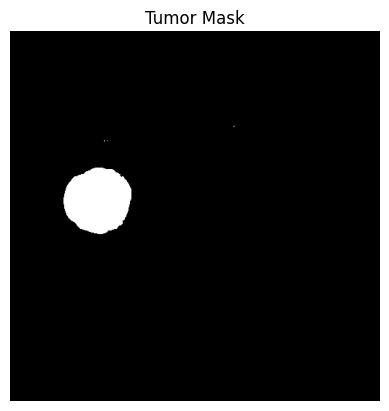

In [11]:
# Let's visualize the 3D tumor mask using a maximum intensity projection (MIP)
# MIP along the slice axis (Z-axis)
mip = tumor_mask_3d.max(axis=2)  
plt.imshow(mip, cmap='gray')
plt.title("Tumor Mask")
plt.axis('off')
plt.show()


#### Generate Rotating MIP Animation
After constructing the 3D tumor mask volume, we proceed to creating a rotating Maximum Intensity Projection (MIP) animation to visually explore the tumor distribution across different anatomical planes and viewing angles. This helps to better understand the tumor’s spatial extent within the body, especially when dealing with complex 3D shapes.

Here’s how I approached the animation:

1. Setting up rotation and projection parameters:
The 3D volume is rotated around the Superior-Inferior (SI) axis. The rotation is performed in the plane defined by the Right-Left and Anterior-Posterior axes. MIP projections are computed along the Coronal and Sagittal planes.

2. Defining rotation angles:
A complete 360° rotation is divided into 60 equally spaced frames, providing a smooth and continuous animation.

3. Rotating the volumes:
At each rotation angle, both the CT volume and the 3D tumor mask are rotated. The volume shape is preserved by disabling reshaping during rotation.

4. Computing MIP slices:
After rotation, Maximum Intensity Projections are computed along the Coronal and Sagittal axes for both the CT and tumor volumes.

5. Normalizing CT MIPs:
Normalization is applied to the CT MIPs to scale intensity values to the [0, 1] range. This normalization prepares the images for RGB rendering and overlay.

6. Applying tumor mask overlays:
RGB versions of the CT MIPs are generated, and the tumor masks are applied using alpha blending with a red color overlay. 

7. Rendering and storing animation frames:
For each frame, side-by-side views of the Coronal and Sagittal MIPs are rendered. The rendered images are captured from the figure canvas and stored as RGB frames.

8. Saving the animated GIF:
After all frames are generated, they are compiled into a GIF file and saved. The animation is set to loop infinitely for continuous playback.

This rotating MIP animation serves as a valuable visualization tool, which gives a good overview of tumor structure and orientation within the scanned volume. The result is embedded below


In [12]:
# Let's print some useful orientation information about the slices
# This is useful for understanding the spatial orientation of the slices
d1 = ref_ct_slices[0]['dataset'] 
d2 = ref_ct_slices[1]['dataset']
print("Orientation:", d1.ImageOrientationPatient)
print("Position:", d1.ImagePositionPatient)
print("Patient Position:", d1.PatientPosition)

print("Orientation:", d2.ImageOrientationPatient)
print("Position:", d2.ImagePositionPatient)
print("Patient Position:", d2.PatientPosition)

print("\n")
print("Pixel Spacing:", d1.PixelSpacing)
print("Slice Thickness:", d1.SliceThickness)

Orientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
Position: [-181.754684, -153.064056, -242.125000]
Patient Position: FFS
Orientation: [1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]
Position: [-181.754684, -153.064056, -237.125000]
Patient Position: FFS


Pixel Spacing: [0.703125, 0.703125]
Slice Thickness: 5.000000


In [13]:
pixel_spacing = d1.PixelSpacing  # [row_spacing, col_spacing] → [dy, dx]
slice_thickness = float(d1.SliceThickness)

dx = pixel_spacing[1]  # Column spacing (X direction)
dy = pixel_spacing[0]  # Row spacing (Y direction)
dz = slice_thickness

aspect_ratios = {
    "Axial": dy / dx,           
    "Coronal": dz / dx,         
    "Sagittal": dz / dy        
}
print(f"Aspect Ratios: Axial: {aspect_ratios['Axial']:.2f}, Coronal: {aspect_ratios['Coronal']:.2f}, Sagittal: {aspect_ratios['Sagittal']:.2f}")


Aspect Ratios: Axial: 1.00, Coronal: 7.11, Sagittal: 7.11


In [14]:
def resample_to_isotropic(volume, spacing, target_spacing=1.0, order=1):
    """
    Resamples a 3D volume to isotropic spacing using scipy.ndimage.zoom.

    Args:
        volume: 3D numpy array
        spacing: (dy, dx, dz) in mm
        target_spacing: desired spacing (default 1.0 mm isotropic)
        order: interpolation order (1 for CT, 0 for masks)
    Returns:
        Resampled 3D numpy array
    """
    dy, dx, dz = spacing
    zoom_factors = (
        dy / target_spacing,
        dx / target_spacing,
        dz / target_spacing
    )
    return scipy.ndimage.zoom(volume, zoom=zoom_factors, order=order)

def overlay_mip(ct_img_norm, tumor_mask=None, liver_mask=None, segmented_mask=None, alpha=0.25,
                tumor_color=(1, 0, 0), liver_color=(0, 1, 0), seg_color=(0, 0, 1)):
    """Overlay binary masks on a normalized grayscale CT image."""
    rgb = np.stack([ct_img_norm] * 3, axis=-1)

    def apply_mask(mask, color):
        mask_bool = mask > 0
        for c in range(3):
            rgb[..., c][mask_bool] = (
                (1 - alpha) * rgb[..., c][mask_bool] + alpha * color[c]
            )

    if liver_mask is not None:
        apply_mask(liver_mask, liver_color)
    if tumor_mask is not None:
        apply_mask(tumor_mask, tumor_color)
    if segmented_mask is not None:
        apply_mask(segmented_mask, seg_color)

    return (rgb * 255).astype(np.uint8)


In [15]:
def create_mip_animation(ct_volume, tumor_mask_3d, liver_mask_3d, 
                         tumor_3d_mask_segment=None, spacing=(0.703, 0.703, 5.0),
                         resample=True, target_spacing=1.0,
                         num_frames=120, gif_frame_duration_ms=100, 
                         window_level=50, window_width=400, alpha_overlay=0.25,
                         output_gif_path='mip_animation.gif'):
    """
    Generates rotating MIP animations (Axial, Coronal, Sagittal) with overlays.
    Automatically resamples to isotropic spacing if requested.
    """
    if resample:
        print("Resampling volumes to isotropic spacing...") # Let's be debug-aware
        ct_volume = resample_to_isotropic(ct_volume, spacing, target_spacing=target_spacing, order=1)
        tumor_mask_3d = resample_to_isotropic(tumor_mask_3d, spacing, target_spacing=target_spacing, order=0)
        liver_mask_3d = resample_to_isotropic(liver_mask_3d, spacing, target_spacing=target_spacing, order=0)
        if tumor_3d_mask_segment is not None:
            tumor_3d_mask_segment = resample_to_isotropic(tumor_3d_mask_segment, spacing, target_spacing=target_spacing, order=0)
        spacing = (1.0, 1.0, 1.0)  # Update after resampling

    # Define aspect ratios from updated spacing
    dy, dx, dz = spacing
    aspect_ratios = {
        "Axial": dy / dx,
        "Coronal": dz / dx,
        "Sagittal": dz / dy
    }

    views = {
        'Axial': {'rot_axes': (0, 1), 'mip_axis': 2},
        'Coronal': {'rot_axes': (1, 2), 'mip_axis': 1},
        'Sagittal': {'rot_axes': (0, 1), 'mip_axis': 0},
    }

    angles = np.linspace(0, 360, num_frames, endpoint=False)
    frames = []

    print(f"\nGenerating rotating MIP animation with {num_frames} frames...")

    for i, angle in enumerate(angles):
        mip_images = []

        for view_name, params in views.items():
            rot_axes = params['rot_axes']
            mip_axis = params['mip_axis']

            # Rotate volumes
            ct_rot = scipy.ndimage.rotate(ct_volume, angle=angle, axes=rot_axes, reshape=False, order=1, mode='nearest')
            tumor_rot = scipy.ndimage.rotate(tumor_mask_3d, angle=angle, axes=rot_axes, reshape=False, order=0, mode='constant')
            liver_rot = scipy.ndimage.rotate(liver_mask_3d, angle=angle, axes=rot_axes, reshape=False, order=0, mode='constant')
            seg_rot = None
            if tumor_3d_mask_segment is not None:
                seg_rot = scipy.ndimage.rotate(tumor_3d_mask_segment, angle=angle, axes=rot_axes, reshape=False, order=0, mode='constant')

            # Generate MIPs
            ct_mip = np.max(ct_rot, axis=mip_axis)
            ct_mip_norm = apply_window(ct_mip, level=window_level, width=window_width)
            tumor_mip = np.max(tumor_rot, axis=mip_axis)
            liver_mip = np.max(liver_rot, axis=mip_axis)
            seg_mip = np.max(seg_rot, axis=mip_axis) if seg_rot is not None else None

            # Overlay and rotate to correct orientation
            fused_img = overlay_mip(ct_mip_norm, tumor_mip, liver_mip, segmented_mask=seg_mip, alpha=alpha_overlay)
            if view_name in ['Coronal', 'Sagittal']:
                fused_img = np.rot90(fused_img, k=1) # For Coronal and Sagittal views, we need to rotate the image

            mip_images.append((view_name, fused_img))

        # Render frame
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), facecolor='black')
        fig.suptitle(f'MIP Views at {angle:.1f}° Rotation', fontsize=16, color='white')

        for ax, (view_name, img) in zip(axes, mip_images):
            aspect = aspect_ratios.get(view_name, "auto")
            ax.imshow(img, aspect=aspect)
            ax.set_title(f'{view_name}', color='white')
            ax.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.93])
        fig.canvas.draw()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
        frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (4,))[:, :, :3]
        plt.close(fig)
        frames.append(frame)

        if (i + 1) % 10 == 0 or i == num_frames - 1:
            print(f"  Frame {i + 1}/{num_frames} generated")

    print(f"\nSaving MIP animation to: {output_gif_path}")
    imageio.mimsave(output_gif_path, frames, duration=gif_frame_duration_ms / 1000, loop=0)
    print("GIF saved successfully.")

In [ ]:
pixel_spacing = d1.PixelSpacing  # [row_spacing, col_spacing] -> [dy, dx]
slice_thickness = float(d1.SliceThickness)

spacing = (pixel_spacing[0], pixel_spacing[1], slice_thickness)  # (dy, dx, dz)

create_mip_animation(
    ct_volume=ct_volume,
    tumor_mask_3d=tumor_mask_3d,
    liver_mask_3d=liver_mask_3d,
    tumor_3d_mask_segment=None,
    spacing=spacing,
    resample=True,
    target_spacing=1.0,
    num_frames=60,
    gif_frame_duration_ms=200,
    output_gif_path='mip_animation.gif'
)


Resampling volumes to isotropic spacing...

Generating rotating MIP animation with 60 frames...
  Frame 10/60 generated
  Frame 20/60 generated
  Frame 30/60 generated
  Frame 40/60 generated
  Frame 50/60 generated
  Frame 60/60 generated

Saving MIP animation to: mip_animation.gif
GIF saved successfully.


![MIP Animation](mip_animation.gif)

[Click here to return to table of content](#table-of-content)

### Task 2: 3D Image Segmentation
In this task, a semi-automatic segmentation approach is applied to refine the tumor mask using intensity-based region growing. We begin by computing spatial characteristics such as the bounding box and centroid.

Steps:

1. Extracting Tumor Region Properties:
The input 3D tumor mask is first validated to ensure that it contains non-zero voxels. The following steps are then performed:
    - Bounding Box Calculation:  
    A bounding box is computed by identifying the minimum and maximum voxel indices along each axis where the tumor mask is positive. This will be used as a spatial constraint for the region of interest.

    - Centroid Calculation:
    The centroid (center of mass) of the tumor region is calculated. This value serves as the seed point for the subsequent segmentation process. The centroid is arranged in (row, column, slice) order.

2. Preparing for Region Growing Segmentation:
The centroid coordinates are converted to (x, y, z) format, where the axes represent (column, row, slice). Using this seed point, the CT intensity value at the centroid is extracted. A lower and upper intensity threshold is defined using a fixed tolerance around this value (e.g., ±10 HU). These thresholds define the intensity range for including voxels in the segmented region.


3. Performing Region Growing Segmentation:
The segmentation is carried out using the `ConnectedThresholdImageFilter` from SimpleITK:

- The CT volume is transposed to match SimpleITK’s (z, y, x) memory layout before conversion.
- A light Gaussian smoothing (`sigma=1.0`) is applied to reduce noise in the CT volume.
- Region growing is performed starting from the seed point using the specified intensity range.
- The resulting binary mask is post-processed as follows:
  - Connected Component Labeling: Connected regions are identified and sorted by size.
  - Largest Component Extraction: The largest connected region is assumed to correspond to the tumor.
  - Morphological Closing: A closing operation is applied using a structuring element of size [7, 7, 3] to fill small gaps and smooth the mask.


In [18]:
pixel_spacing = [0.703125, 0.703125]
slice_thickness = 5.000000

#### Extracting Tumor Bounding-Box and Centroid

In [ ]:
# Let's start by checking and printing some basic information
if tumor_mask_3d is None or np.sum(tumor_mask_3d) == 0:
    raise Exception("Error: The tumor mask is empty or not loaded. Cannot proceed.")

print(f"Extracting Bounding Box and Centroid")
print(f"Input tumor mask shape: {tumor_mask_3d.shape}")
print(f"Number of tumor voxels: {np.sum(tumor_mask_3d)}")

# Calculate 3D Bounding Box 
# Find the indices where the mask is non-zero
coords = np.argwhere(tumor_mask_3d > 0) # Returns N x 3 array of [row, col, slice] indices

if coords.size == 0:
    print("Error: No positive voxels found in the mask to calculate bounding box.")
    bbox = None
else:
    # Find min and max coordinates along each axis
    r_min, c_min, s_min = coords.min(axis=0)
    r_max, c_max, s_max = coords.max(axis=0)

    # Bounding box format: (min_row, min_col, min_slice, max_row, max_col, max_slice)
    # Note: max values are inclusive indices
    bbox = (r_min, c_min, s_min, r_max, c_max, s_max)
    print("\nCalculated Bounding Box (min_row, min_col, min_slice, max_row, max_col, max_slice):")
    print(f"  {bbox}")
    print(f"  Dimensions (R, C, S): ({r_max-r_min+1}, {c_max-c_min+1}, {s_max-s_min+1})")


# Calculate Centroid 
# The centroid is the geometric center (center of mass for a binary mask)
# We can use scipy.ndimage.center_of_mass to calculate this directly
# Input should be the mask itself according to the docs.
centroid = None
if coords.size > 0:
    try:
        # Returns coordinates in (row, col, slice) order
        centroid = scipy.ndimage.center_of_mass(tumor_mask_3d)
        print("\nCalculated Centroid (row, col, slice):")
        # Format to reasonable precision for printing
        print(f"  ({centroid[0]:.2f}, {centroid[1]:.2f}, {centroid[2]:.2f})")
    except Exception as e:
        print(f"Error calculating centroid: {e}")
else:
     print("\nCannot calculate centroid: No positive voxels found in the mask.")


Extracting Bounding Box and Centroid
Input tumor mask shape: (512, 512, 41)
Number of tumor voxels: 48646

Calculated Bounding Box (min_row, min_col, min_slice, max_row, max_col, max_slice):
  (np.int64(131), np.int64(74), np.int64(18), np.int64(280), np.int64(310), np.int64(36))
  Dimensions (R, C, S): (150, 237, 19)

Calculated Centroid (row, col, slice):
  (233.28, 119.62, 30.79)


Let's visualize the bounding box and the tumor's centroid on a representative slides

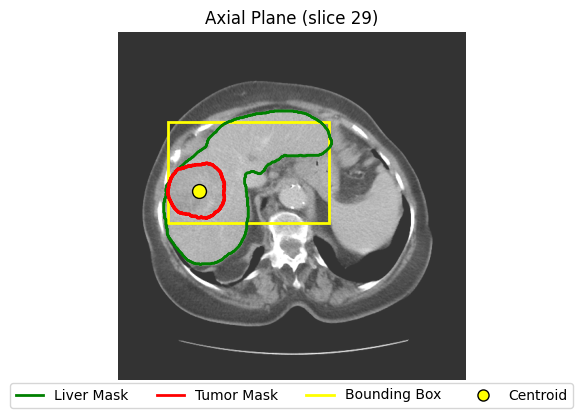

In [356]:
# Get slice indices for each plane
axial_slice_id = 29     # This slice contains both the tumor and liver segmentations
coronal_mid = ct_volume.shape[0] // 2     # Middle slice along y-axis  
sagittal_mid = ct_volume.shape[1] // 2  # Set specific axial slice index
axial_slice_idx = 29

# Extract axial slice
ct_slice_axial = ct_volume[:, :, axial_slice_idx]
tumor_slice_axial = tumor_mask_3d[:, :, axial_slice_idx]
liver_slice_axial = liver_mask_3d[:, :, axial_slice_idx]

# Apply windowing for better visualization
window_level = 50
window_width = 400
ct_slice_axial_windowed = apply_window(ct_slice_axial, level=window_level, width=window_width)

# Create figure with single subplot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Display axial view
ax.imshow(ct_slice_axial_windowed, cmap='gray', alpha=0.8)
ax.contour(liver_slice_axial, colors='green', linewidths=1.5, alpha=0.7)
ax.contour(tumor_slice_axial, colors='red', linewidths=2.0, alpha=0.9)

# Add bounding box and centroid for axial
if bbox is not None:
    r_min, c_min, s_min, r_max, c_max, s_max = bbox
    if s_min <= axial_slice_idx <= s_max:
        rect = plt.Rectangle((c_min, r_min), c_max-c_min, r_max-r_min, 
                           fill=False, color='yellow', linewidth=2)
        ax.add_patch(rect)

if centroid is not None:
    ax.plot(centroid[1], centroid[0], 'yo', markersize=10, markerfacecolor='yellow', 
            markeredgecolor='black', markeredgewidth=1)

ax.set_title(f'Axial Plane (slice {axial_slice_idx})')
ax.axis('off')

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='green', lw=2, label='Liver Mask'),
    Line2D([0], [0], color='red', lw=2, label='Tumor Mask'),
    Line2D([0], [0], color='yellow', lw=2, label='Bounding Box'),
    Line2D([0], [0], marker='o', color='yellow', lw=0, markersize=8, 
           markeredgecolor='black', label='Centroid')
]
fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.05), ncol=4)

plt.tight_layout()
plt.show()

#### Estimating Tumor region using Region Growing Algorithm

Semi-Automatic Segmentation using Region Growing Algorithm
Using intensity at seed (119, 233, 30): 91.00 HU
Setting thresholds: Lower=87, Upper=94
Running SimpleITK ConnectedThreshold filter...


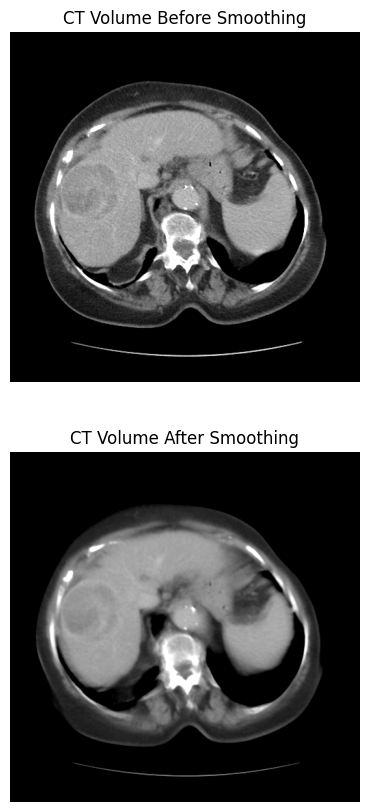

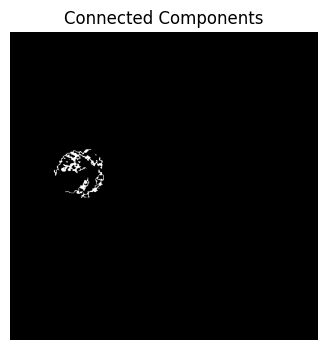

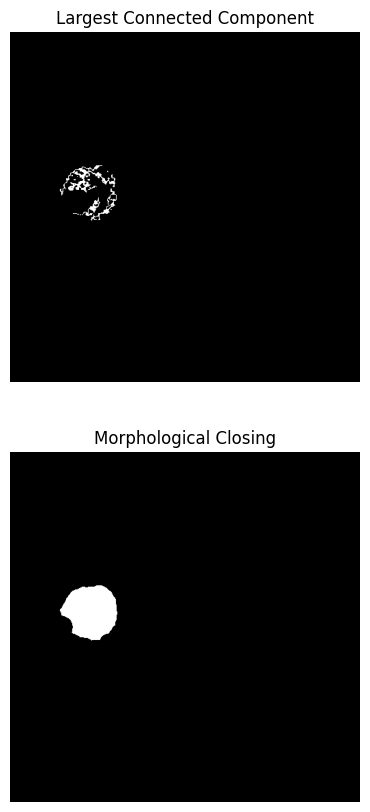

Segmentation finished. Result shape: (512, 512, 41)
Number of segmented voxels: 35549


In [20]:
print(f"Semi-Automatic Segmentation using Region Growing Algorithm")

tumor_mask_3d_segmented = None # Initialize segmented mask

if centroid is not None:
    # Parameters for ConnectedThreshold 
    # Convert float centroid coordinates to integer indices for seed point
    # Note: According to the docs, SimpleITK uses (x, y, z) = (col, row, slice) convention for coordinates!
    # So we need to convert from (row, col, slice) to (col, row, slice)
    seed_point = (int(centroid[1]), int(centroid[0]), int(centroid[2])) # (col, row, slice)

    # Determine intensity thresholds. This threshold is sensitive and requires tuning.
    # Strategy: We can use intensity at seed point +/- a tolerance
    try:
        seed_intensity = ct_volume[int(centroid[0]), int(centroid[1]), int(centroid[2])]
        intensity_tolerance = 3.5 # Tolerance in HU - (I experimentally found this value to work well)
        # Set lower and upper thresholds based on seed intensity and tolerance
        lower_threshold = int(seed_intensity - intensity_tolerance)
        upper_threshold = int(seed_intensity + intensity_tolerance)
        print(f"Using intensity at seed {seed_point}: {seed_intensity:.2f} HU")
        print(f"Setting thresholds: Lower={lower_threshold}, Upper={upper_threshold}")
    except IndexError:
         print(f"Error: Centroid {seed_point} is outside the CT volume bounds {ct_volume.shape}. Cannot determine seed intensity.")
         lower_threshold, upper_threshold = None, None # Prevent proceeding

    if lower_threshold is not None and upper_threshold is not None:
        try:
            # Let's visualize a sample slice from the CT volume before the smoothing
            plt.figure(figsize=(10, 10))
            plt.subplot(2, 1, 1)
            plt.imshow(apply_window(ct_volume[:, :, 29], 50, 400), cmap="gray")
            plt.title("CT Volume Before Smoothing")
            plt.axis("off")

            # Convert NumPy CT volume to SimpleITK image
            # Note: We have to ensure that ct_volume is in a suitable format (e.g., int16, float32) according to the docs
            # SimpleITK expects image data in (z, y, x) = (slice, row, col) order when creating from NumPy
            # but uses (x,y,z) for functions like SetSeed. Let's transpose if needed.
            # Note: ct_volume is originally in (row, col, slice) from previous task 1:
            ct_volume_sitk = sitk.GetImageFromArray(ct_volume.transpose(2, 0, 1)) # Transpose to (slice, row, col)

            # Perform Region Growing 
            region_grower = sitk.ConnectedThresholdImageFilter()
            region_grower.SetSeedList([seed_point]) # Set the starting point (x, y, z)
            region_grower.SetLower(lower_threshold)    # Minimum intensity to include
            region_grower.SetUpper(upper_threshold)    # Maximum intensity to include
            region_grower.SetReplaceValue(1) # Value to assign to segmented pixels  

            print("Running SimpleITK ConnectedThreshold filter...")
            # Apply smoothing to the CT volume before segmentation
            ct_smoothed = sitk.SmoothingRecursiveGaussian(ct_volume_sitk, sigma=1.0)

            # Visualize slice after application of smoothing
            plt.subplot(2, 1, 2)
            plt.imshow(apply_window(sitk.GetArrayFromImage(ct_smoothed)[29, :, :], 50, 400), cmap="gray")
            plt.title("CT Volume After Smoothing")
            plt.axis("off")
            plt.show()

            # Perform region growing on the smoothed image
            segmented_mask_sitk = region_grower.Execute(ct_smoothed)

            # Find  connected component in the segmented mask
            cc = sitk.ConnectedComponent(segmented_mask_sitk)
            relabeled = sitk.RelabelComponent(cc, sortByObjectSize=True) # Relabel components by size
            # Visualize the found connected components
            plt.figure(figsize=(4, 4))
            relabeled_np = sitk.GetArrayFromImage(relabeled)
            plt.imshow(relabeled_np[29, :, :], cmap="gray")
            plt.title("Connected Components")
            plt.axis("off")
            plt.show()
            
            # Keep the largest component (assuming it's the tumor)
            largest_component = relabeled == 1
            largest_component_np = sitk.GetArrayFromImage(largest_component)
            plt.figure(figsize=(10, 10))
            # Plot largest component mask
            plt.subplot(2, 1, 1)
            plt.imshow(largest_component_np[29, :, :], cmap="gray")
            plt.title("Largest Connected Component")
            plt.axis("off")
            # Perform morphological closing to fill small holes in the segmented mask
            closed = sitk.BinaryMorphologicalClosing(largest_component, [15, 15, 4]) # expeerimentally worked well
            closed_np = sitk.GetArrayFromImage(closed)
            plt.subplot(2, 1, 2)
            plt.imshow(closed_np[29, :, :], cmap="gray")
            plt.title("Morphological Closing")
            plt.axis("off")
            plt.show()

            # Convert the resulting SimpleITK mask back to NumPy array
            # The output array will be in (slice, row, col) order
            segmented_mask_np = sitk.GetArrayFromImage(closed)

            # Transpose back to original (row, col, slice) order to match input/ground truth
            tumor_mask_3d_segmented = segmented_mask_np.transpose(1, 2, 0)

            print(f"Segmentation finished. Result shape: {tumor_mask_3d_segmented.shape}")
            print(f"Number of segmented voxels: {np.sum(tumor_mask_3d_segmented)}")

        except Exception as e:
            print(f"Error during SimpleITK region growing: {e}")
            tumor_mask_3d_segmented = None # Ensure it's None if error occurs
    else:
        print("Skipping segmentation due to invalid thresholds.")

else:
    print("Skipping segmentation: Centroid was not calculated successfully.")


#### Evaluation and Comparison
After generating the 3D tumor segmentation using region growing, both quantitative and qualitative evaluations are carried out to assess the performance of the segmentation relative to the ground truth mask.

Here are the steps I took:

1. Numerical Evaluation
To quantify segmentation accuracy, the following performance metrics are computed:
    - Dice Similarity Coefficient (DSC): 
    Measures the overlap between the predicted and ground truth masks. It is defined as:  
    $$
    DSC = \frac{2 \cdot |A \cap B|}{|A| + |B|}
    $$ 
    where \( A \) and \( B \) are the binary masks. This is equivalent to the F1-score for binary classification.

    - Precision: Indicates the proportion of predicted positive voxels that are truly positive.

    - Sensitivity (Recall): Reflects the proportion of actual positive voxels correctly identified by the segmentation.

    - Specificity: Measures the proportion of negative voxels correctly excluded from the segmented region.

These metrics are computed using pixel-wise comparisons between the segmented mask and the reference mask. 

2. Visual Comparison
For visual assessment, a representative 2D slice is selected—specifically, the slice corresponding to the z-index of the computed tumor centroid. The following visualizations are  generated:

- CT slice with ground truth contour: 
  The original CT slice is shown with the ground truth tumor mask overlaid in red.

- CT slice with segmented mask contour:  
  The same CT slice is shown with the predicted segmentation overlaid in lime green.

- Combined overlay of both masks:
  Both the ground truth and predicted segmentation masks are overlaid on the CT slice using different contour styles. This allows for easy assessment of discrepancies visually.

In addition to the plots, the computed performance metrics (Precision, Sensitivity, Specificity, F1-score) are displayed to aid evaluation of the algorithm’s performance.

In [21]:
def dice_coefficient(mask1, mask2):
    """
    Compute the Dice Similarity Coefficient (DSC) between two binary masks.
    DSC = 2 * |A intersect B| / (|A| + |B|)
    """
    # Ensure boolean type
    mask1 = mask1 > 0
    mask2 = mask2 > 0

    intersection = np.sum(mask1 & mask2)
    volume1 = np.sum(mask1)
    volume2 = np.sum(mask2)

    # Handle potential division by zero
    if volume1 + volume2 == 0:
        return 1.0 if intersection == 0 else 0.0 # Both empty or identical empty masks
    else:
        return 2.0 * intersection / (volume1 + volume2)
    
def perpixel_performance_measures(mask_reference, mask_prediction):
    """Compute TP, TN, FP, FN from binary masks."""
    true_positives = np.sum((mask_reference == 1) & (mask_prediction == 1))
    true_negatives = np.sum((mask_reference == 0) & (mask_prediction == 0))
    false_positives = np.sum((mask_reference == 0) & (mask_prediction == 1))
    false_negatives = np.sum((mask_reference == 1) & (mask_prediction == 0))
    return true_positives, true_negatives, false_positives, false_negatives

def perimage_performance_measures(mask_reference, mask_prediction):
    """Compute sensitivity, specificity, and F1-score from binary masks."""
    tp, tn, fp, fn = perpixel_performance_measures(mask_reference, mask_prediction)
    sensitivity = tp / (tp + fn) if (tp + fn) else 0.0
    specificity = tn / (tn + fp) if (tn + fp) else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) else 0.0
    return precision, sensitivity, specificity, f1_score


Calculating Numerical Metrics...
  Dice Similarity Coefficient (DSC): 0.7899
  Precision: 0.9354
  Sensitivity: 0.6836
  Specificity: 0.9998
  F1-score: 0.7899

Generating Visual Comparison...


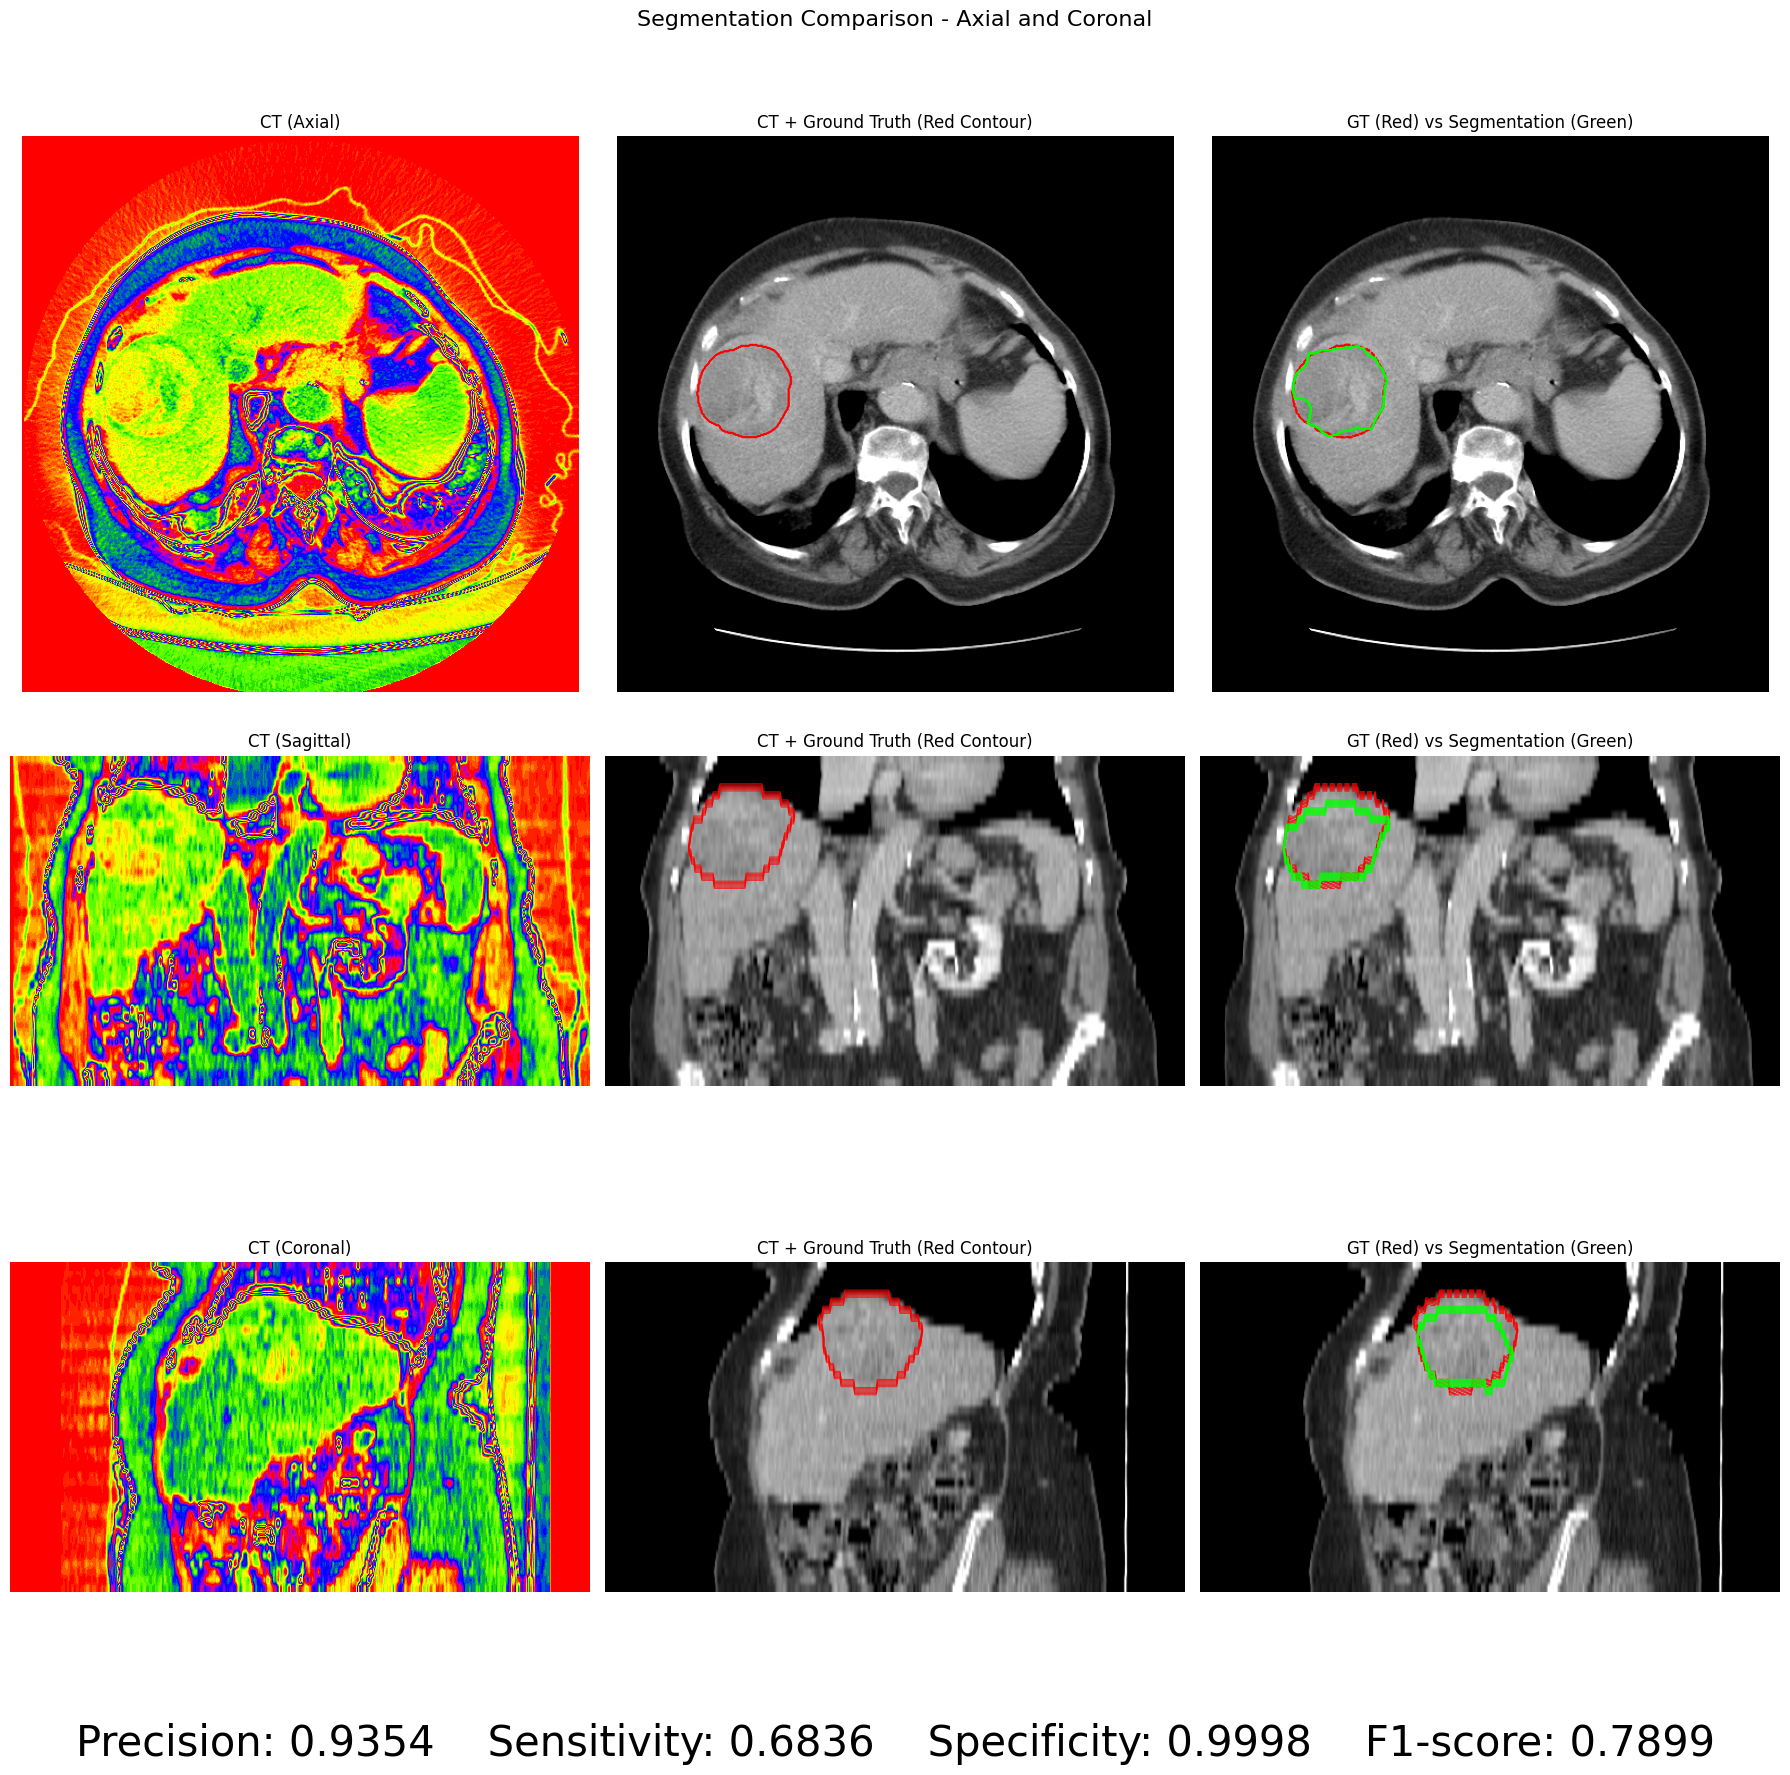

In [333]:
if tumor_mask_3d_segmented is None:
    print("Segmentation was not performed or failed. Cannot evaluate.")
else:
    # Numerical Evaluation
    print("\nCalculating Numerical Metrics...")
    dsc_score = dice_coefficient(tumor_mask_3d, tumor_mask_3d_segmented)  # Same as F1 score for binary masks
    print(f"  Dice Similarity Coefficient (DSC): {dsc_score:.4f}")
    precision, sensitivity, specificity, f1_score = perimage_performance_measures(tumor_mask_3d, tumor_mask_3d_segmented)
    print(f"  Precision: {precision:.4f}")
    print(f"  Sensitivity: {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  F1-score: {f1_score:.4f}")
   
    # Visual Evaluation
    print("\nGenerating Visual Comparison...")

    # Select a representative slice (e.g., the slice containing the centroid)
    if centroid is not None:
        # Axial Plane (Z-axis index)
        axial_slice_idx = int(centroid[2])
        ct_slice_axial = ct_volume[:, :, axial_slice_idx]
        gt_mask_slice_axial = tumor_mask_3d[:, :, axial_slice_idx]
        seg_mask_slice_axial = tumor_mask_3d_segmented[:, :, axial_slice_idx]

        # Coronal Plane (Y-axis index)
        coronal_idx = int(centroid[1])
        ct_slice_coronal = ct_volume[:, coronal_idx, :]
        gt_mask_slice_coronal = tumor_mask_3d[:, coronal_idx, :]
        seg_mask_slice_coronal = tumor_mask_3d_segmented[:, coronal_idx, :]

        # Sagittal Plane (X-axis index)
        sagittal_idx = int(centroid[0])
        ct_slice_sagittal = ct_volume[sagittal_idx, :, :]
        gt_mask_slice_sagittal = tumor_mask_3d[sagittal_idx, :, :]
        seg_mask_slice_sagittal = tumor_mask_3d_segmented[sagittal_idx, :, :] 

        # Apply windowing to CT slices for better visualization
        window_level = 50
        window_width = 400
        ct_slice_axial_windowed = apply_window(ct_slice_axial, level=window_level, width=window_width)
        ct_slice_sagittal_windowed = apply_window(ct_slice_sagittal, level=window_level, width=window_width)
        ct_slice_coronal_windowed = apply_window(ct_slice_coronal, level=window_level, width=window_width)

        # Aspect ratio adjustments (to preserve anatomical proportions)
        aspect_ratio_coronal = slice_thickness / pixel_spacing[1]
        aspect_ratio_sagittal = slice_thickness / pixel_spacing[0]
        # Rotate Sagittal and Coronal planes for better visualization
        ct_slice_sagittal = np.rot90(ct_slice_sagittal, k=1)
        gt_mask_slice_sagittal = np.rot90(gt_mask_slice_sagittal, k=1)
        seg_mask_slice_sagittal = np.rot90(seg_mask_slice_sagittal, k=1)
        ct_slice_sagittal_windowed = np.rot90(ct_slice_sagittal_windowed, k=1)

        ct_slice_coronal = np.rot90(ct_slice_coronal, k=1)
        gt_mask_slice_coronal = np.rot90(gt_mask_slice_coronal, k=1)
        seg_mask_slice_coronal = np.rot90(seg_mask_slice_coronal, k=1)
        ct_slice_coronal_windowed = np.rot90(ct_slice_coronal_windowed, k=1)


        # Create plot for all three planes in separate rows
        fig, axes = plt.subplots(3, 3, figsize=(18, 18))
        fig.suptitle(f'Segmentation Comparison - Axial and Coronal', fontsize=16)

        # Axial Plane (Row 1)
        axes[0, 0].imshow(ct_slice_axial, cmap='prism')
        axes[0, 0].set_title('CT (Axial)')
        axes[0, 0].axis('off')

        axes[0, 1].imshow(ct_slice_axial_windowed, cmap='gray')
        axes[0, 1].contour(gt_mask_slice_axial, colors='red', linewidths=0.8, alpha=0.7)
        axes[0, 1].set_title('CT + Ground Truth (Red Contour)')
        axes[0, 1].axis('off')

        axes[0, 2].imshow(ct_slice_axial_windowed, cmap='gray')
        axes[0, 2].contour(gt_mask_slice_axial, colors='red', linewidths=1.0, linestyles='dashed', alpha=0.8)
        axes[0, 2].contour(seg_mask_slice_axial, colors='lime', linewidths=1.0, alpha=0.8)
        axes[0, 2].set_title('GT (Red) vs Segmentation (Green)')
        axes[0, 2].axis('off')

        # Sagittal Plane (Row 2)
        axes[1, 0].imshow(ct_slice_sagittal, cmap='prism', aspect=aspect_ratio_sagittal)
        axes[1, 0].set_title('CT (Sagittal)')
        axes[1, 0].axis('off')

        axes[1, 1].imshow(ct_slice_sagittal_windowed, cmap='gray', aspect=aspect_ratio_sagittal)
        axes[1, 1].contour(gt_mask_slice_sagittal, colors='red', linewidths=0.8, alpha=0.7)
        axes[1, 1].set_title('CT + Ground Truth (Red Contour)')
        axes[1, 1].axis('off')

        axes[1, 2].imshow(ct_slice_sagittal_windowed, cmap='gray', aspect=aspect_ratio_sagittal)
        axes[1, 2].contour(gt_mask_slice_sagittal, colors='red', linewidths=1.0, linestyles='dashed', alpha=0.8)
        axes[1, 2].contour(seg_mask_slice_sagittal, colors='lime', linewidths=1.0, alpha=0.8)
        axes[1, 2].set_title('GT (Red) vs Segmentation (Green)')
        axes[1, 2].axis('off')

        # Coronal Plane (Row 3)
        axes[2, 0].imshow(ct_slice_coronal, cmap='prism', aspect=aspect_ratio_coronal)
        axes[2, 0].set_title('CT (Coronal)')
        axes[2, 0].axis('off')

        axes[2, 1].imshow(ct_slice_coronal_windowed, cmap='gray', aspect=aspect_ratio_coronal)
        axes[2, 1].contour(gt_mask_slice_coronal, colors='red', linewidths=0.8, alpha=0.7)
        axes[2, 1].set_title('CT + Ground Truth (Red Contour)')
        axes[2, 1].axis('off')

        axes[2, 2].imshow(ct_slice_coronal_windowed, cmap='gray', aspect=aspect_ratio_coronal)
        axes[2, 2].contour(gt_mask_slice_coronal, colors='red', linewidths=1.0, linestyles='dashed', alpha=0.8)
        axes[2, 2].contour(seg_mask_slice_coronal, colors='lime', linewidths=1.0, alpha=0.8)
        axes[2, 2].set_title('GT (Red) vs Segmentation (Green)')
        axes[2, 2].axis('off')

        # Display metrics below the figure
        metrics_text = (
            f"Precision: {precision:.4f}    "
            f"Sensitivity: {sensitivity:.4f}    "
            f"Specificity: {specificity:.4f}    "
            f"F1-score: {f1_score:.4f}"
        )

        fig.text(0.5, 0.01, metrics_text, ha='center', fontsize=30, color='black')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("Cannot determine central slice for visualization as centroid is missing.")

In [319]:
create_mip_animation(ct_volume=ct_volume, tumor_mask_3d=tumor_mask_3d, 
                     tumor_3d_mask_segment=tumor_mask_3d_segmented, liver_mask_3d=liver_mask_3d,
                       output_gif_path='mip_animation_segmented.gif', num_frames=60)

Resampling volumes to isotropic spacing...

Generating rotating MIP animation with 60 frames...
  Frame 10/60 generated
  Frame 20/60 generated
  Frame 30/60 generated
  Frame 40/60 generated
  Frame 50/60 generated
  Frame 60/60 generated

Saving MIP animation to: mip_animation_segmented.gif
GIF saved successfully.


![Segmented Tumor vs Ground-Truth](mip_animation_segmented.gif)

[Click here to return to table of content](#table-of-content)

#### Task 3: Image Co-Registration

First, let's define methods for loading the landmarks, and for performing the ridgid co=reggistration. 

In [394]:
def load_fcsv(filename):
    """Load .fcsv file and return landmarks as an array of x, y, z coordinates."""
    landmarks = []
    with open(filename, newline='') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            if not row or row[0].startswith('#'):
                continue
            x, y, z = float(row[1]), float(row[2]), float(row[3])
            landmarks.append([x, y, z])
    return np.array(landmarks)

In [395]:
def compute_rigid_transform_kabsch(P, Q):
    """
    Compute rigid transformation between two point sets using the Kabsch algorithm.
    P: Input points
    Q: Reference points
    Returns: Rotation matrix R and translation vector t
    """
    centroid_P = np.mean(P, axis=0)
    centroid_Q = np.mean(Q, axis=0)
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q
    H = P_centered.T @ Q_centered
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T
    t = centroid_Q - R @ centroid_P
    return R, t


def rotation_matrix_to_quaternion(R):
    """Convert 3x3 rotation matrix to quaternion [w, x, y, z]."""
    trace = np.trace(R)
    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (R[2, 1] - R[1, 2]) * s
        y = (R[0, 2] - R[2, 0]) * s
        z = (R[1, 0] - R[0, 1]) * s
    elif R[0, 0] > R[1, 1] and R[0, 0] > R[2, 2]:
        s = 2.0 * np.sqrt(1.0 + R[0, 0] - R[1, 1] - R[2, 2])
        w = (R[2, 1] - R[1, 2]) / s
        x = 0.25 * s
        y = (R[0, 1] + R[1, 0]) / s
        z = (R[0, 2] + R[2, 0]) / s
    elif R[1, 1] > R[2, 2]:
        s = 2.0 * np.sqrt(1.0 + R[1, 1] - R[0, 0] - R[2, 2])
        w = (R[0, 2] - R[2, 0]) / s
        x = (R[0, 1] + R[1, 0]) / s
        y = 0.25 * s
        z = (R[1, 2] + R[2, 1]) / s
    else:
        s = 2.0 * np.sqrt(1.0 + R[2, 2] - R[0, 0] - R[1, 1])
        w = (R[1, 0] - R[0, 1]) / s
        x = (R[0, 2] + R[2, 0]) / s
        y = (R[1, 2] + R[2, 1]) / s
        z = 0.25 * s
    return np.array([w, x, y, z])

def estimate_initial_qt(input_files, ref_files):
    """
    Estimate initial quaternion and translation parameters from landmark files.
    Returns: 7D parameter vector [qw, qx, qy, qz, tx, ty, tz]
    """
    input_coords = [load_fcsv(f) for f in input_files]
    ref_coords = [load_fcsv(f) for f in ref_files]
    P = np.vstack(input_coords)
    Q = np.vstack(ref_coords)
    R, t = compute_rigid_transform_kabsch(P, Q)
    q = rotation_matrix_to_quaternion(R)
    return np.concatenate([q, t])


def quaternion_to_rotation_matrix(q):
    """
    Convert a unit quaternion into a 3x3 rotation matrix.
    q: array-like, shape (4,) [qw, qx, qy, qz]
    """
    q = q / np.linalg.norm(q)
    qw, qx, qy, qz = q
    return np.array([
        [1 - 2*(qy**2 + qz**2),     2*(qx*qy - qw*qz),     2*(qx*qz + qw*qy)],
        [    2*(qx*qy + qw*qz), 1 - 2*(qx**2 + qz**2),     2*(qy*qz - qw*qx)],
        [    2*(qx*qz - qw*qy),     2*(qy*qz + qw*qx), 1 - 2*(qx**2 + qy**2)]
    ])


def apply_rigid_transform(qt, coords):
    """
    Apply a rigid transformation to coordinates using quaternion + translation.
    qt: array-like, shape (7,) — quaternion (4,) + translation (3,)
    coords: shape (3, D, H, W)
    Returns transformed coordinates of same shape
    """
    q = qt[:4]
    t = qt[4:]
    R = quaternion_to_rotation_matrix(q)
    
    flat_coords = coords.reshape(3, -1)  # shape (3, N)
    transformed = R @ flat_coords + t[:, None]
    return transformed.reshape(coords.shape)


def invert_quaternion(q):
    """Invert a unit quaternion [w, x, y, z]."""
    w, x, y, z = q
    return np.array([w, -x, -y, -z])  # Inverse for unit quaternions


def invert_transform(qt):
    """Compute inverse of a rigid transform represented by qt = [q, t]."""
    q = qt[:4]
    t = qt[4:]
    q_inv = invert_quaternion(q)
    R = quaternion_to_rotation_matrix(q)
    R_inv = R.T
    t_inv = -R_inv @ t
    return np.concatenate([q_inv, t_inv])

In [396]:
def create_coordinate_grid(shape):
    """
    Create a 3D coordinate grid of shape (3, D, H, W) for the given volume shape.
    shape: tuple —> (depth, height, width)
    Returns: numpy array with coordinates in the order (x, y, z)
    """
    D, H, W = shape
    z, y, x = np.meshgrid(np.arange(D), np.arange(H), np.arange(W), indexing='ij')
    coords = np.stack([x, y, z], axis=0).astype(np.float32)  # shape (3, D, H, W)
    return coords


def resample_input_volume(input_volume, transformed_coords, order=1):
    """
    Resample the input volume at transformed coordinates using interpolation.
    input_volume: ndarray — the input CT volume, shape (H, W, D)
    transformed_coords: ndarray — transformed coordinates, shape (3, D, H, W)
    order: int — interpolation order (1=linear, 0=nearest)
    Returns: resampled volume in the shape of the reference
    """
    # Reorder coordinates to match (z, y, x) order expected by map_coordinates
    zyx_coords = [transformed_coords[2], transformed_coords[1], transformed_coords[0]]
    
    resampled = map_coordinates(input_volume, zyx_coords, order=order, mode='nearest')
    return resampled

In [397]:
def compute_normalized_mutual_information(vol1, vol2, bins=64):
    """
    Compute normalized mutual information (NMI) between two 3D volumes.
    vol1, vol2: flattened 1D arrays (same shape)
    bins: number of histogram bins
    Returns: normalized mutual information value (float)
    """
    hist_2d, _, _ = np.histogram2d(vol1.ravel(), vol2.ravel(), bins=bins)
    pxy = hist_2d / np.sum(hist_2d)  # Joint probability
    px = np.sum(pxy, axis=1)         # Marginal for vol1
    py = np.sum(pxy, axis=0)         # Marginal for vol2

    # Compute entropies
    Hx = -np.sum(px[px > 0] * np.log(px[px > 0]))
    Hy = -np.sum(py[py > 0] * np.log(py[py > 0]))
    Hxy = -np.sum(pxy[pxy > 0] * np.log(pxy[pxy > 0]))

    # Normalized Mutual Information
    nmi = (Hx + Hy) / Hxy if Hxy > 0 else 0
    return nmi


def mutual_information_loss(qt, input_volume, ref_volume, ref_coords, norm_method='zscore'):
    """
    Compute the negative normalized mutual information (NMI) between transformed input and reference.
    qt: 7D parameter vector — quaternion (4) + translation (3)
    input_volume: ndarray, shape (H, W, D) — moving image
    ref_volume: ndarray, shape (H, W, D) — fixed image
    ref_coords: ndarray — coordinate grid of shape (3, D, H, W)
    norm_method: str — normalization method ('minmax' or 'zscore')
    """

    # Transform and resample
    transformed_coords = apply_rigid_transform(qt, ref_coords)
    warped_input = resample_input_volume(input_volume, transformed_coords, order=1)

    # Compute NMI
    nmi = compute_normalized_mutual_information(ref_volume, warped_input)
    return -nmi  # Minimize negative NMI


#### Optimizer
We define the optimizer to use our cost function (mutual information loss) which uses the normalized mutual information to calculate the loss.

We don't need to define the optimizer from scratch; for efficiency, we are better-off using libraries!

In [398]:
def optimize_registration(input_volume, ref_volume, ref_coords, initial_qt):
    """
    Optimize the rigid transformation (quaternion + translation) to align input_volume to ref_volume.
    Returns the optimal 7D parameter vector and loss history for visualization.
    """
    
    # Track loss history and iterations
    loss_history = []
    iteration_count = 0
    
    # Objective function wrapper 
    def objective(qt):
        nonlocal iteration_count
        iteration_count += 1
        
        # Normalize quaternion part to ensure it represents a valid rotation
        qt_normalized = qt.copy()
        qt_normalized[:4] = qt_normalized[:4] / np.linalg.norm(qt_normalized[:4])
        
        # Calculate loss
        loss = mutual_information_loss(qt_normalized, input_volume, ref_volume, ref_coords)
        loss_history.append(loss)
        
        if iteration_count % 100 == 0:
            print(f"Iteration {iteration_count}: Loss = {loss:.6f}")
        
        return loss

    print("Starting optimization...")
    result = minimize(
        objective,
        initial_qt,
        method='Nelder-Mead',  # TODO: Try other optimizers Powell, L-BFGS-B -> Powell also worked well for this problem!
        options={'maxiter': 1500, 'disp': True, 'adaptive': True} # 'ftol': 1e-5, 'gtol': 1e-5, 'eps': 1e-5
    )
    
    print(f"\nOptimization completed:")
    print(f"Total iterations: {iteration_count}")
    print(f"Final loss: {result.fun:.6f}")
    print(f"Success: {result.success}")

    return result.x, loss_history

def plot_loss_history(loss_history, title="Registration Loss History", save_path=None):
    """
    Visualize the loss history during optimization.
    
    Parameters:
    loss_history: list of loss values
    title: plot title
    save_path: optional path to save the plot
    """
    plt.figure(figsize=(12, 8))
    
    # Create subplots
    fig, (ax1) = plt.subplots(1, 1, figsize=(12, 10))
    
    # Plot Full loss history
    ax1.plot(loss_history, 'b-', linewidth=2, alpha=0.8)
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Loss Value')
    ax1.set_title(f'{title} - Full History')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, len(loss_history))
    
    # Add statistics to the plot
    min_loss = min(loss_history)
    min_iter = loss_history.index(min_loss)
    ax1.scatter(min_iter, min_loss, color='red', s=100, zorder=5, 
                label=f'Min Loss: {min_loss:.6f} at iter {min_iter}')
    ax1.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\nLoss History Summary:")
    print(f"Initial loss: {loss_history[0]:.6f}")
    print(f"Final loss: {loss_history[-1]:.6f}")
    print(f"Minimum loss: {min_loss:.6f} (iteration {min_iter})")
    print(f"Loss reduction: {loss_history[0] - loss_history[-1]:.6f}")
    print(f"Relative improvement: {((loss_history[0] - loss_history[-1]) / loss_history[0] * 100):.2f}%")



def transform_liver_mask(liver_mask, optimal_qt, ref_coords):
    """
    Transform the liver mask using the optimal transformation.
    Use nearest-neighbor interpolation to preserve labels.
    """
    transformed_coords = apply_rigid_transform(optimal_qt, ref_coords)
    transformed_mask = resample_input_volume(liver_mask.astype(np.float32), transformed_coords, order=0)
    return transformed_mask.astype(np.uint8)


In [399]:
def preprocess_input_volume(input_ct_volume, ref_ct_volume, slice_to_remove=41):
    """
    Preprocess the input CT volume to match the reference volume dimensions.
    
    Args:
        input_ct_volume: Input CT volume (shape H×W×D, where D=42)
        ref_ct_volume: Reference CT volume (shape H×W×D, where D=41)
        
    Returns:
        Preprocessed input volume with shape matching reference volume
    """
    input_shape = input_ct_volume.shape
    ref_shape = ref_ct_volume.shape
    
    print(f"Original input volume shape: {input_shape}")
    print(f"Reference volume shape: {ref_shape}")
    
    # Check if dimensions mismatch in the depth (Z) dimension
    if input_shape[2] != ref_shape[2]:
        print(f"Dimension mismatch detected: Input depth={input_shape[2]}, Reference depth={ref_shape[2]}")
        
        # Method 1: Remove the last slice 
        if input_shape[2] - ref_shape[2] == 1:
            # Calculate middle slice to remove
            # middle_slice = input_shape[2] // 2
            print(f"Removing slice at index {slice_to_remove} from input volume")
            
            # Remove the middle slice
            processed_volume = np.delete(input_ct_volume, slice_to_remove, axis=2)
            
        # Method 2: For larger differences, use. For our case, we don't need this since the mismatch is only one slice
        else:
            print(f"Using interpolation to match dimensions")
            # Create new coordinate system for resampling
            orig_z = np.linspace(0, 1, input_shape[2])
            new_z = np.linspace(0, 1, ref_shape[2])
            
            processed_volume = np.zeros(ref_shape, dtype=input_ct_volume.dtype)
            
            # Interpolate each 2D slice along z-axis
            for x in range(input_shape[0]):
                for y in range(input_shape[1]):
                    slice_data = input_ct_volume[x, y, :]
                    # Interpolate this line of voxels to the new z coordinates
                    processed_volume[x, y, :] = np.interp(new_z, orig_z, slice_data)
                    
        print(f"Preprocessed input volume shape: {processed_volume.shape}")
        return processed_volume
    
    # If dimensions already match, return the original volume
    return input_ct_volume


def compare_volumes_pre_registration(input_volume, ref_volume):
    """
    Compare input and reference volumes before registration both visually and numerically.
    
    Args:
        input_volume: Preprocessed input CT volume
        ref_volume: Reference CT volume
        
    Returns:
        Dictionary with comparison metrics
    """
    # Calculate basic statistics
    input_mean = np.mean(input_volume)
    ref_mean = np.mean(ref_volume)
    input_std = np.std(input_volume)
    ref_std = np.std(ref_volume)
    
    # Calculate correlation coefficient
    input_flat = input_volume.flatten()
    ref_flat = ref_volume.flatten()
    correlation = np.corrcoef(input_flat, ref_flat)[0, 1]
    
    # Calculate mutual information
    nmi = compute_normalized_mutual_information(input_volume, ref_volume)
    
    # Calculate mean squared error
    mse = np.mean((input_flat - ref_flat) ** 2)
    
    # Visual comparison: Extract middle slices
    middle_slice_idx = input_volume.shape[2] // 2
    input_middle_slice = input_volume[:, :, middle_slice_idx]
    ref_middle_slice = ref_volume[:, :, middle_slice_idx]
    
    # Create overlay of middle slices
    plt.figure(figsize=(12, 6))
    
    # Input slice
    plt.subplot(1, 3, 1)
    plt.imshow(apply_window(input_middle_slice, 50, 400), cmap='gray')
    plt.title("Input Middle Slice")
    plt.axis('off')
    
    # Reference slice
    plt.subplot(1, 3, 2)
    plt.imshow(apply_window(ref_middle_slice, 50, 400), cmap='gray')
    plt.title("Reference Middle Slice")
    plt.axis('off')
    
    # Overlay (red = input, blue = reference)
    plt.subplot(1, 3, 3)
    plt.imshow(ref_middle_slice, cmap='prism', alpha=0.7)
    plt.imshow(input_middle_slice, cmap='prism', alpha=0.7)
    plt.title("Overlay (Pre-Registration)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("pre_registration_comparison.png")
    plt.close()
    # plt.show()
    
    print("Pre-registration comparison:")
    print(f"Input volume statistics: Mean={input_mean:.2f}, Std={input_std:.2f}")
    print(f"Reference volume statistics: Mean={ref_mean:.2f}, Std={ref_std:.2f}")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"Normalized Mutual information: {nmi:.4f}")
    print(f"Mean squared error: {mse:.4f}")
    
    return {
        "input_mean": input_mean,
        "ref_mean": ref_mean,
        "input_std": input_std,
        "ref_std": ref_std,
        "correlation": correlation,
        "mutual_information": nmi,
        "mse": mse
    }


def compare_volumes_post_registration(transformed_volume, ref_volume, metrics_pre=None):
    """
    Compare transformed input and reference volumes after registration.
    
    Args:
        transformed_volume: Transformed input CT volume after registration
        ref_volume: Reference CT volume
        metrics_pre: Dictionary with pre-registration metrics for comparison
        
    Returns:
        Dictionary with comparison metrics
    """
    # Calculate basic statistics
    trans_mean = np.mean(transformed_volume)
    ref_mean = np.mean(ref_volume)
    trans_std = np.std(transformed_volume)
    ref_std = np.std(ref_volume)
    
    # Calculate correlation coefficient
    trans_flat = transformed_volume.flatten()
    ref_flat = ref_volume.flatten()
    correlation = np.corrcoef(trans_flat, ref_flat)[0, 1]
    
    # Calculate mutual information
    nmi = compute_normalized_mutual_information(transformed_volume, ref_volume)
    
    # Calculate mean squared error
    mse = np.mean((trans_flat - ref_flat) ** 2)
    
    # Visual comparison: Extract middle slices
    middle_slice_idx = transformed_volume.shape[2] // 2
    trans_middle_slice = transformed_volume[:, :, middle_slice_idx]
    ref_middle_slice = ref_volume[:, :, middle_slice_idx]
    
    # Create overlay of middle slices
    plt.figure(figsize=(12, 6))
    
    # Transformed slice
    plt.subplot(1, 3, 1)
    plt.imshow(apply_window(trans_middle_slice, 50, 400), cmap='gray')
    plt.title("Transformed Middle Slice")
    plt.axis('off')
    
    # Reference slice
    plt.subplot(1, 3, 2)
    plt.imshow(apply_window(ref_middle_slice, 50, 400), cmap='gray')
    plt.title("Reference Middle Slice")
    plt.axis('off')
    
    # Overlay (red = transformed, blue = reference)
    plt.subplot(1, 3, 3)
    plt.imshow(ref_middle_slice, cmap='Blues', alpha=0.7)
    plt.imshow(trans_middle_slice, cmap='Reds', alpha=0.7)
    plt.title("Overlay (Post-Registration)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig("post_registration_comparison.png")
    plt.close()
    
    print("\nPost-registration comparison:")
    print(f"Transformed volume statistics: Mean={trans_mean:.2f}, Std={trans_std:.2f}")
    print(f"Reference volume statistics: Mean={ref_mean:.2f}, Std={ref_std:.2f}")
    print(f"Correlation coefficient: {correlation:.4f}")
    print(f"Normalized Mutual information: {nmi:.4f}")
    print(f"Mean squared error: {mse:.4f}")
    
    if metrics_pre:
        print("\nImprovement after registration:")
        print(f"Correlation: {correlation - metrics_pre['correlation']:.4f} (higher is better)")
        print(f"Normalized Mutual information: {nmi - metrics_pre['mutual_information']:.4f} (higher is better)")
        print(f"MSE: {metrics_pre['mse'] - mse:.4f} (higher is better)")
    
    return {
        "trans_mean": trans_mean,
        "ref_mean": ref_mean,
        "trans_std": trans_std,
        "ref_std": ref_std,
        "correlation": correlation,
        "mutual_information": nmi,
        "mse": mse
    }

In [400]:
aspect_ratio_coronal = slice_thickness / pixel_spacing[1]
aspect_ratio_sagittal = slice_thickness / pixel_spacing[0]

In [404]:
def visualize_mask_overlay(ref_ct_volume, input_ct_volume, transformed_input_volume, liver_mask, transformed_liver_mask=None,
                           window_level=50, window_width=400,
                           liver_color=(0.0, 1.0, 0.0), alpha=0.3):
    """
    Visualize the liver mask overlaid on axial, coronal, and sagittal slices.
    Shows:
    - Axial slice 27
    - Coronal slice at y=256
    - Sagittal slice at x=256
    """
    slice_axial = 27
    slice_coronal = 256
    slice_sagittal = 256

    def get_slices(vol, mask, transformed_mask, axis, idx):
        if axis == 'axial':
            img = vol[:, :, idx]
            msk = mask[:, :, idx] 
            tmsk = transformed_mask[:, :, idx] if transformed_mask is not None else np.zeros_like(msk)
        elif axis == 'coronal':
            img = vol[:, idx, :]
            msk = mask[:, idx, :]
            tmsk = transformed_mask[:, idx, :] if transformed_mask is not None else np.zeros_like(msk)
        elif axis == 'sagittal':
            img = vol[idx, :, :]
            msk = mask[idx, :, :]
            tmsk = transformed_mask[idx, :, :] if transformed_mask is not None else np.zeros_like(msk)
        return img, msk > 0, tmsk > 0

    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    planes = ['axial', 'coronal', 'sagittal']
    indices = [slice_axial, slice_coronal, slice_sagittal]

    for row, (plane, idx) in enumerate(zip(planes, indices)):
        ref_img, ref_mask, _ = get_slices(ref_ct_volume, liver_mask, None, plane, idx)
        input_img, _, input_trans_mask = get_slices(input_ct_volume, liver_mask, transformed_liver_mask, plane, idx)
        transformed_input_img, _, _ = get_slices(transformed_input_volume, liver_mask, None, plane, idx)

        # Apply windowing
        ref_win = apply_window(ref_img, window_level, window_width)
        input_win = apply_window(input_img, window_level, window_width)
        transformed_input_win = apply_window(transformed_input_img, window_level, window_width)

        ref_rgb = np.stack([ref_win] * 3, axis=-1)
        input_rgb = np.stack([input_win] * 3, axis=-1)
        transformed_input_rgb = np.stack([transformed_input_win] * 3, axis=-1)

        # Overlay masks
        ref_overlay = apply_alpha_overlay(ref_rgb, ref_mask, liver_color, alpha)
        input_overlay_ref = apply_alpha_overlay(input_rgb, ref_mask, liver_color, alpha)
        input_overlay_trans = apply_alpha_overlay(input_rgb, input_trans_mask, liver_color, alpha)
        transformed_input_overlay_ref = apply_alpha_overlay(transformed_input_rgb, ref_mask, liver_color, alpha)
        
        if plane == 'axial':
            axes[row, 0].imshow(ref_overlay)
            axes[row, 0].set_title(f"Ref ({plane.capitalize()} {idx})")
            axes[row, 1].imshow(input_overlay_ref)
            axes[row, 1].set_title(f"Input + Ref Mask ({plane.capitalize()} {idx})")
            axes[row, 2].imshow(input_overlay_trans)
            axes[row, 2].set_title(f"Input + Trans Mask ({plane.capitalize()} {idx})")
            axes[row, 3].imshow(transformed_input_overlay_ref)
            axes[row, 3].set_title(f"Transformed Input + Ref Mask ({plane.capitalize()} {idx})")
        else:
            axes[row, 0].imshow(np.rot90(ref_overlay), aspect=aspect_ratio_coronal if plane == 'coronal' else aspect_ratio_sagittal)
            axes[row, 0].set_title(f"Ref ({plane.capitalize()} {idx})")
            axes[row, 1].imshow(np.rot90(input_overlay_ref), aspect=aspect_ratio_coronal if plane == 'coronal' else aspect_ratio_sagittal) #np.rot90(input_overlay_ref, aspect=aspect_ratio_coronal if plane == 'coronal' else aspect_ratio_sagittal)
            axes[row, 1].set_title(f"Input + Ref Mask ({plane.capitalize()} {idx})")
            axes[row, 2].imshow(np.rot90(input_overlay_trans), aspect=aspect_ratio_coronal if plane == 'coronal' else aspect_ratio_sagittal)
            axes[row, 2].set_title(f"Input + Trans Mask ({plane.capitalize()} {idx})")
            axes[row, 3].imshow(np.rot90(transformed_input_overlay_ref), aspect=aspect_ratio_coronal if plane == 'coronal' else aspect_ratio_sagittal)
            axes[row, 3].set_title(f"Transformed Input + Ref Mask ({plane.capitalize()} {idx})")

        for ax in axes[row]:
            ax.axis('off')

    plt.tight_layout()
    plt.savefig("mask_overlay_multiplanar.png")
    plt.close()

def create_multiplanar_gifs(ref_ct_volume, transformed_input_volume, liver_mask,
                            spacing=(pixel_spacing[0], pixel_spacing[1], slice_thickness),
                            window_level=50, window_width=400,
                            liver_color=(0.0, 1.0, 0.0), alpha=0.3,
                            save_dir='./'):
    
    def get_slice(vol, mask, axis, idx):
        if axis == 'axial':
            img = vol[:, :, idx]
            msk = mask[:, :, idx] > 0
        elif axis == 'coronal':
            img = vol[:, idx, :]
            msk = mask[:, idx, :] > 0
        elif axis == 'sagittal':
            img = vol[idx, :, :]
            msk = mask[idx, :, :] > 0
        return img, msk

    planes = ['axial', 'coronal', 'sagittal']
    shape = ref_ct_volume.shape
    num_slices = {
        'axial': shape[2],
        'coronal': shape[1],
        'sagittal': shape[0]
    }

    for plane in planes:
        frames = []
        for idx in range(num_slices[plane]):
            img, mask = get_slice(transformed_input_volume, liver_mask, plane, idx)
            
            # Apply windowing
            img_win = apply_window(img, window_level, window_width)
            img_rgb = np.stack([img_win]*3, axis=-1)

            # Overlay mask
            overlay = apply_alpha_overlay(img_rgb, mask, liver_color, alpha)

            # Aspect ratio correction & rotation
            if plane == 'axial':
                # Axial slices shape: (x, y), spacing_x, spacing_y
                # No resizing needed because displayed as is
                display_img = overlay

            elif plane == 'coronal':
                # Coronal slices shape: (x, z)
                # We want to scale z axis to match x axis in mm
                spacing_x, spacing_y, spacing_z = spacing
                zoom_factor_x = 1.0
                zoom_factor_y = spacing_z / spacing_x  # height scaling

                # zoom expects shape order (height, width, channels)
                # overlay shape: (x, z, 3) but in numpy terms (rows=x, cols=z)
                display_img = zoom(overlay, (zoom_factor_x, zoom_factor_y, 1), order=1)
                display_img = np.rot90(display_img)

            elif plane == 'sagittal':
                # Sagittal slices shape: (y, z)
                spacing_x, spacing_y, spacing_z = spacing
                zoom_factor_x = 1.0
                zoom_factor_y = spacing_z / spacing_y

                display_img = zoom(overlay, (zoom_factor_x, zoom_factor_y, 1), order=1)
                display_img = np.rot90(display_img)

            # Convert to uint8 for GIF frame
            display_img_uint8 = (display_img * 255).astype(np.uint8)
            frames.append(display_img_uint8)

        gif_path = f"{save_dir}{plane}_transformed_input_ref_mask.gif"
        imageio.mimsave(gif_path, frames, duration=0.5, loop=0)
        print(f"Saved {plane} GIF at {gif_path}")

In [405]:
def transform_input_volume(input_volume, optimal_qt, ref_coords):
    """
    Transform the entire input volume using the optimal transformation.
    
    Args:
        input_volume: Input CT volume
        optimal_qt: Optimal quaternion + translation parameters
        ref_coords: Reference coordinate grid
        
    Returns:
        Transformed input volume
    """
    transformed_coords = apply_rigid_transform(optimal_qt, ref_coords)
    transformed_volume = resample_input_volume(input_volume, transformed_coords, order=1)
    return transformed_volume


# Main function that orchestrates the co-registration pipeline
def perform_ct_coregistration(ref_ct_dir, input_ct_dir, liver_mask_path=None):
    """
    Perform co-registration between reference and input CT volumes.
    
    Args:
        ref_ct_dir: Directory containing reference CT DICOM files
        input_ct_dir: Directory containing input CT DICOM files
        liver_mask_path: Path to liver segmentation mask (optional)
        
    Returns:
        Dictionary with registration results
    """
    # We can follow the following steps to run the co-registration pipeline
    print("Step 1: Loading and sorting CT slices...")
    ref_ct_slices = load_and_sort_ct_slices(ref_ct_dir)
    input_ct_slices = load_and_sort_ct_slices(input_ct_dir)
    
    if not ref_ct_slices or not input_ct_slices:
        raise ValueError("Error: No valid CT slices loaded.")
    
    print(f"Loaded {len(ref_ct_slices)} reference CT slices and {len(input_ct_slices)} input CT slices.")
    
    # Create 3D volumes
    try:
        ref_ct_volume = np.stack([s['dataset'].pixel_array for s in ref_ct_slices], axis=-1)
        input_ct_volume = np.stack([s['dataset'].pixel_array for s in input_ct_slices], axis=-1)
        print(f"Created Reference CT volume with shape: {ref_ct_volume.shape}")
        print(f"Created Input CT volume with shape: {input_ct_volume.shape}")
    except Exception as e:
        raise ValueError(f"Could not stack CT slices into volume: {e}")
    
    # Preprocess input volume to match reference dimensions
    print("\nStep 2: Preprocessing input volume to match reference dimensions...")
    processed_input_volume = preprocess_input_volume(input_ct_volume, ref_ct_volume)
    
    # Compare volumes before registration
    print("\nStep 3: Comparing volumes before registration...")
    pre_reg_metrics = compare_volumes_pre_registration(processed_input_volume, ref_ct_volume)
    
    # Compute initial transformation from landmarks
    print("\nStep 4: Computing initial transformation...")
    input_files = [
        "Data/in_mark_1.fcsv",
        "Data/in_mark_2.fcsv",
        "Data/in_mark_3.fcsv"
    ]

    ref_files = [
        "Data/ref_mark_1.fcsv",
        "Data/ref_mark_2.fcsv",
        "Data/ref_mark_3.fcsv"
    ]

    initial_qt = estimate_initial_qt(input_files, ref_files)
    print(f"Initial quaternion + translation: {initial_qt}") 
    
    # Transpose volumes to (D, H, W) for registration
    ref_ct_vol = np.transpose(ref_ct_volume, (2, 0, 1))
    processed_input_vol = np.transpose(processed_input_volume, (2, 0, 1))
    
    # Create coordinate grid for reference volume
    print("\nStep 5: Creating coordinate grid...")
    ref_coords = create_coordinate_grid(ref_ct_vol.shape)
    
    # Optimize registration
    print("\nStep 6: Optimizing registration...")
    optimal_qt, loss_history = optimize_registration(processed_input_vol, ref_ct_vol, ref_coords, initial_qt)
    # optimal_qt, loss_history = optimize_registration_least_squares(processed_input_vol, ref_ct_vol, ref_coords, initial_qt)
    print(f"Optimal quaternion + translation: {optimal_qt}")
    
    # Transform input volume using optimal transformation
    print("\nStep 7: Transforming input volume...")
    transformed_input_vol = transform_input_volume(processed_input_vol, optimal_qt, ref_coords)
    
    # Convert back to original orientation for visualization and comparison
    transformed_input_volume = np.transpose(transformed_input_vol, (1, 2, 0))
    ref_ct_volume_transposed = np.transpose(ref_ct_vol, (1, 2, 0))
    
    # Compare volumes after registration
    print("\nStep 8: Comparing volumes after registration...")
    post_reg_metrics = compare_volumes_post_registration(transformed_input_volume, ref_ct_volume_transposed, pre_reg_metrics)
    
    # Transform liver mask if provided
    if liver_mask_path:
        print("\nStep 9: Transforming liver mask...")
        try:
            seg = defaultdict(str)
            segmentations = load_segmentation(liver_seg_path, 'Liver', seg)
            liver_mask = construct_3d_mask(ref_ct_slices, segmentations, segment_name='Liver')
            
            # Transpose mask to match coordinate system
            liver_mask_transposed = np.transpose(liver_mask, (2, 0, 1))
            
            # Compute inverse transformation
            inverse_qt = invert_transform(optimal_qt)
            print(f"Inverse quaternion + translation: {inverse_qt}")
            
            # Apply inverse transformation to liver mask
            warped_liver_mask = transform_liver_mask(liver_mask_transposed, inverse_qt, ref_coords)
            
            # Transpose back for visualization
            warped_liver_mask = np.transpose(warped_liver_mask, (1, 2, 0))
            
            # Visualize warped mask overlay on input volume
            visualize_mask_overlay(ref_ct_volume, input_ct_volume[:, :, :-1], transformed_input_volume,
                                    liver_mask, warped_liver_mask)
                                    
            # Create multi-plane gif 
            create_multiplanar_gifs(ref_ct_volume, transformed_input_volume, liver_mask)
            
            print("Liver mask transformation complete.")
        except Exception as e:
            print(f"Error transforming liver mask: {e}")
    else:
        print("No liver mask provided, skipping mask transformation.")
    
    # Return registration results
    return {
        "pre_registration_metrics": pre_reg_metrics,
        "post_registration_metrics": post_reg_metrics,
        "optimal_transform": optimal_qt,
        "inverse_transform": invert_transform(optimal_qt) if 'optimal_qt' in locals() else None,
        "transformed_volume": transformed_input_volume if 'transformed_input_volume' in locals() else None,
        "lost_history": loss_history
    }

In [406]:
# Paths to reference and input CT series
ref_ct_dir = r"Data\30_EQP_Ax5.00mm" # Path to reference CT series
input_ct_dir = r"Data\11_AP_Ax5.00mm" # Path to input CT series
liver_mask_path = r"Data\30_EQP_Ax5.00mm_ManualROI_Liver.dcm"

try:
    results = perform_ct_coregistration(ref_ct_dir, input_ct_dir, liver_mask_path)
    print("\nRegistration completed successfully!")
except Exception as e:
    print(f"Registration failed: {e}")

Step 1: Loading and sorting CT slices...
Found 42 CT files. Performing initial scan...
All files belong to SeriesInstanceUID: 1801040320200103051513090319.222.3.4
Most common rounded X/Y position: (-181.75, -153.06) found in 41 slices.
Excluded 1 slice(s) due to inconsistent X/Y position.
Loading pixel data and performing final checks for 41 slices...
Successfully loaded and sorted 41 CT slices.
Verified all loaded slices belong to AcquisitionNumber: 3
Verified all loaded slices have consistent X/Y position (approx. -181.75, -153.06)
Found 43 CT files. Performing initial scan...
All files belong to SeriesInstanceUID: 1801040320200103051513090319.222.1.0
Most common rounded X/Y position: (-182.46, -154.12) found in 42 slices.
Excluded 1 slice(s) due to inconsistent X/Y position.
Loading pixel data and performing final checks for 42 slices...
Successfully loaded and sorted 42 CT slices.
Verified all loaded slices belong to AcquisitionNumber: 1
Verified all loaded slices have consistent X

<Figure size 1200x800 with 0 Axes>

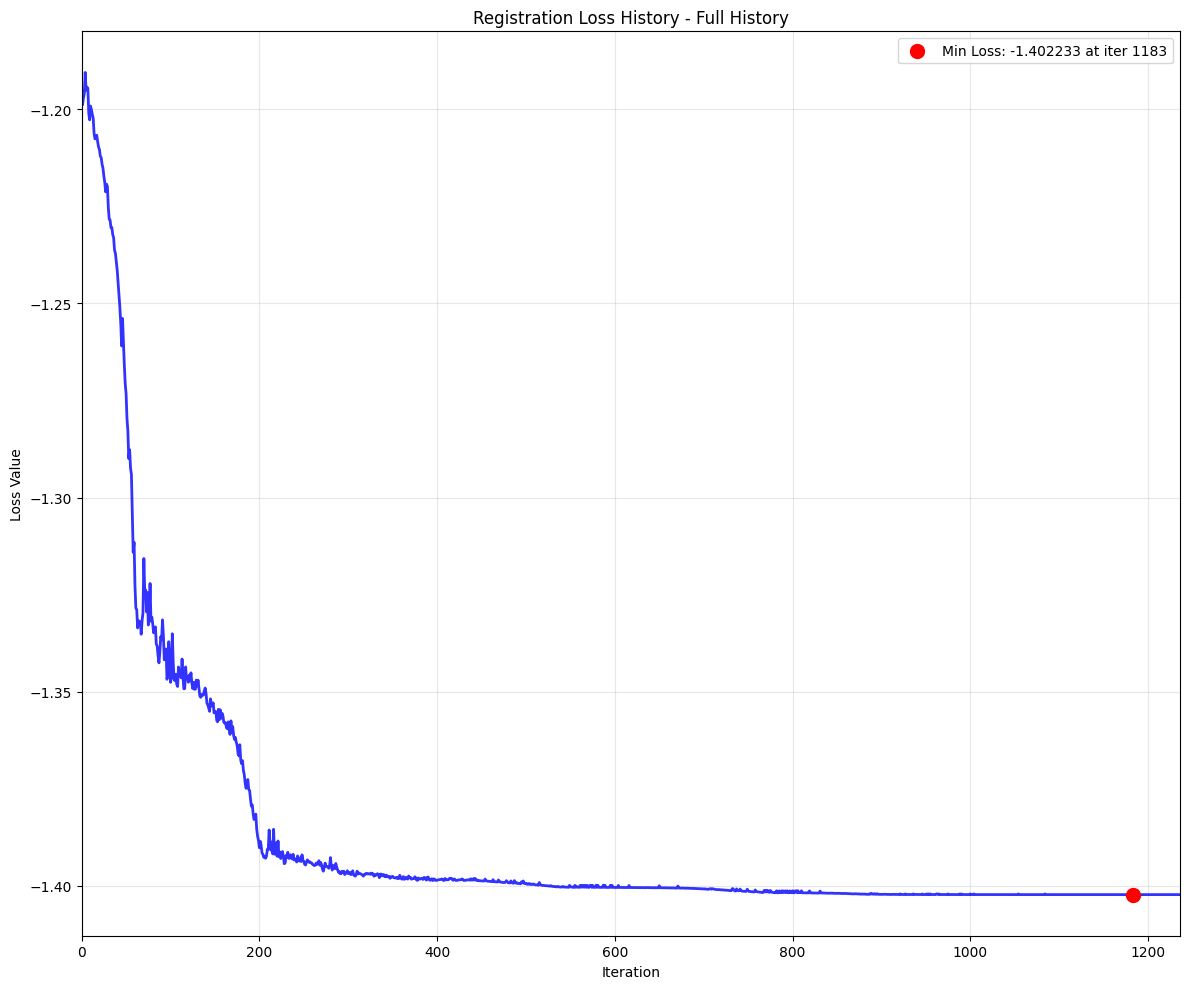


Loss History Summary:
Initial loss: -1.194722
Final loss: -1.402232
Minimum loss: -1.402233 (iteration 1183)
Loss reduction: 0.207510
Relative improvement: -17.37%


In [392]:
plot_loss_history(loss_history=results['lost_history'], title="Registration Loss History", save_path=None)

[Click here to return to table of content](#table-of-content)